In [ ]:
%load_ext autoreload  
%autoreload 2

In [ ]:
import pandas as pd
import geopandas as gpd
import swifter

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import stc_unicef_cpi.data.process_geotiff as pg
import h3.api.numpy_int as h3

from pathlib import Path


In [ ]:
base_dir = Path("/Users/johnf/Downloads/higher_res_dssg/")
tiff_dir = base_dir / "500m_res"
econ_dir = base_dir / "econ"
clean_base = base_dir / "nga_clean_v2.csv"
rwi_path = base_dir / "NGA_relative_wealth_index.csv"
comm_zns = base_dir / "commuting-zones-bdrys.csv"
connectivity_dir = base_dir / "connectivity"
fb_conn = connectivity_dir / "fb_nigeria.csv"

int_dir = Path("../data/interim/")



# Look at survey counts by country

In [ ]:
all_data = pd.read_csv('../data/raw/childpoverty_microdata_gps_21jun22.csv') 

In [ ]:
import pycountry 

country = "ghana"
country = pycountry.countries.search_fuzzy(country)[0]
country_name = country.name 
country_code = country.alpha_3 

In [ ]:
country_code

In [ ]:
all_data.dropna(subset=['LATNUM','LONGNUM'],inplace=True)

In [ ]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [ ]:
world[world.name == country_name]

In [ ]:
ctry_cnts = all_data.countrycode.value_counts()
_idx = ctry_cnts.index.tolist() 
conts = [world[world.iso_a3==idx].continent.values[0] if len(world[world.iso_a3==idx].name)>0 else idx for idx in _idx] 
_idx = [world[world.iso_a3==idx].name.values[0] if len(world[world.iso_a3==idx].name)>0 else idx for idx in _idx] 
ctry_cnts = pd.DataFrame(ctry_cnts)
ctry_cnts['continent'] = conts 
ctry_cnts.index = _idx
ctry_cnts.head()

In [ ]:
import seaborn as sns
fig,ax = plt.subplots(dpi=200)
sns.barplot(data=ctry_cnts[ctry_cnts.continent=='Africa'],x=ctry_cnts[ctry_cnts.continent=='Africa'].index,y='countrycode',ax=ax)
ax.set_ylabel('No. surveys')
ax.set_xlabel('Country')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.show()

In [ ]:
fig,ax = plt.subplots(dpi=200)
ctry_cnts.plot.bar()
plt.show()

# Gen rows for model training params

In [ ]:
c1 = np.array(["all", "nigeria", "senegal"])
c2 = np.array(["normal", "stratified", "spatial"])
c3 = np.array(["all", "health", "nutrition","av-3-prevalence",
            "av-4-prevalence",])
c4 = np.array(["none", "mean", "median", "knn", "linear", "rf"])
c5 = np.array(["none", "standard", "minmax", "robust"])
c6 = np.array(["none", "log", "power"])
c7 = np.array(["normal", "stratified", "spatial"])
c8 = np.array(["true", "false"])
c9 = np.array(["true", "false"])
c10 = np.array(["true", "false"])

# all, spatial, all, median, robust, none, normal, true, true, true (?)

params = np.array(np.meshgrid(c1, c2, c3, c4, c5, c6, c7, c8, c9, c10)).T.reshape(-1, 10)
# np.savetxt('../src/stc_unicef_cpi/models/clean_params.txt',params,delimiter=' ',fmt='%s')

In [ ]:
params.shape

# Spatial CV tests

In [ ]:
from stc_unicef_cpi.data.cv_loaders import cv_split  

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
nga = world[world.name == "Nigeria"].geometry.__geo_interface__['features'][0]['geometry']
nga_hex = h3.polyfill(nga,res=7)

In [ ]:
base_dir = Path("/Users/johnf/Downloads/higher_res_dssg/")
all_data = base_dir / "clean_nga_w_autov1.csv"
thr_data = base_dir / "nga_clean_v2_thr30.csv"
all_df = pd.read_csv(all_data)
all_df["name_commuting_zone"] = all_df["name_commuting_zone"].astype("category")
thr_df = pd.read_csv(thr_data)
thr_all = all_df.set_index("hex_code").loc[thr_df.hex_code].reset_index()


In [ ]:
import seaborn as sns

k = 10
N = 1000
samp_hex = np.random.choice(thr_all["hex_code"], size=N, replace=False)
labels = np.random.rand(N)
folds = cv_split(samp_hex, labels=labels, k=k, mode="spatial")
# sns.distplot(folds,kde=False, bins=k)
fig, ax = plt.subplots(dpi=150)
latlongs = np.array([h3.h3_to_geo(hex) for hex in samp_hex])
for _, test_idxs in folds:
    ax.scatter(latlongs[test_idxs, 1], latlongs[test_idxs, 0])
plt.show()


In [ ]:
from stc_unicef_cpi.data.cv_loaders import HexSpatialKFold

latlongs = np.array([h3.h3_to_geo(hex) for hex in samp_hex])
for train_idx, test_idx in HexSpatialKFold().split(samp_hex, labels):
    fig, ax = plt.subplots(dpi=150)
    ax.scatter(latlongs[train_idx, 1], latlongs[train_idx, 0], c="g")
    ax.scatter(latlongs[test_idx, 1], latlongs[test_idx, 0], c="r")
    plt.show()


# Connectivity data

In [ ]:
# import dask.dataframe as dd
# from dask.delayed import delayed
# parts = delayed(pd.read_excel)(connectivity_dir / 'cell_tower_nga.xlsx',
#                                     sheet_name=0)
# df = dd.from_delayed(parts)
nga_cell_df = pd.read_excel(connectivity_dir / "cell_tower_nga.xlsx", sheet_name=0)


In [ ]:
nga_cell_df.head()
# will just want radio (generation category - want counts / cell if possible)
# and possibly avg_signal, though generally 0
# Most likely just overall count will be most useful


In [ ]:
nga_cell_df["hex_code"] = nga_cell_df[["lat", "long"]].swifter.apply(
    lambda x: h3.geo_to_h3(x[0], x[1], resolution=7), axis=1
)


In [ ]:
nga_cell_df = nga_cell_df[["hex_code", "radio", "avg_signal"]]


In [ ]:
nga_cell_df.groupby(["hex_code", "radio"]).size().unstack(level=1).fillna(0).join(
    nga_cell_df.groupby("hex_code").avg_signal.mean()
).to_csv(connectivity_dir / "nga_cell_clean.csv")


In [ ]:
import shapely.wkt

# speed_df = dd.read_csv(connectivity_dir/"speedtest_world.csv",blocksize=25e6).set_index("Unnamed: 0")  # 25MB chunks
speed_df = pd.read_csv(Path('../data/external/connectivity') / "2021-10-01_performance_mobile_tiles.csv")
# speed_df["geometry"] = speed_df.geometry.swifter.apply(shapely.wkt.loads)
ctry = "Nigeria" 
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ctry = world[world.name == ctry]

In [ ]:
speed_df.geometry.head()

In [ ]:
# alt version
bd_series = speed_df.geometry.str.replace("POLYGON\s\(+|\)","").str.split(r"\s|,\s")
speed_df['min_x'] = bd_series.str[1].astype('float')
speed_df['max_y'] = bd_series.str[-1].astype('float')
minx, miny, maxx, maxy = ctry.bounds.values.T.squeeze()
res_df = speed_df[speed_df.min_x.between(minx-1e-2,maxx+1e-2)&speed_df.max_y.between(miny-1e-2,maxy+1e-2)].copy()
res_df['geometry'] = res_df.geometry.swifter.apply(shapely.wkt.loads)
res_df = gpd.GeoDataFrame(res_df, crs="epsg:4326")

nga_speed_df = gpd.sjoin(
    res_df, ctry, how="inner", op="intersects"
)


In [ ]:
# original version 
speed_df["geometry"] = speed_df.geometry.swifter.apply(shapely.wkt.loads)
speed_df = gpd.GeoDataFrame(speed_df, crs="epsg:4326")
nga_speed_df = gpd.sjoin(
    speed_df, ctry, how="inner", op="intersects"
)


In [ ]:
# def centroid_lat_from_shply(wkt_str):
#     try:
#         return shapely.wkt.loads(wkt_str).centroid.coords.xy[1]
#     except:
#         # assume wkt reading error
#         return np.nan
# def centroid_long_from_shply(wkt_str):
#     try:
#         return shapely.wkt.loads(wkt_str).centroid.coords.xy[0]
#     except:
#         # assume wkt reading error
#         return np.nan

# def centroid_latlong_from_shply(wkt_str):
#     try:
#         return np.array(shapely.wkt.loads(wkt_str).centroid.coords.xy).flatten()
#     except:
#         # assume wkt reading error
#         return np.array([np.nan,np.nan])

# # speed_df['lat'] = speed_df.geometry.apply(centroid_lat_from_shply, meta=('geometry', float))
# # speed_df['long'] = speed_df.geometry.apply(centroid_long_from_shply, meta=('geometry', float))
# # speed_df[['lat','long']] = speed_df.geometry.swifter.apply(centroid_latlong_from_shply)
# speed_df['lat'] = speed_df.geometry.swifter.apply(centroid_lat_from_shply)


In [ ]:
tmp = nga_speed_df.geometry.swifter.apply(
    lambda x: pd.Series(np.array(x.centroid.coords.xy).flatten())
)


In [ ]:
nga_speed_df[["long", "lat"]] = tmp


In [ ]:
nga_speed_df["hex_code"] = nga_speed_df[["lat", "long"]].swifter.apply(
    lambda row: h3.geo_to_h3(row[0], row[1], 7), axis=1
)


In [ ]:
nga_speed_df.to_csv(connectivity_dir / "speedtest_nga.csv", index=False)


# Main data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
nga_cell_df = pd.read_csv(connectivity_dir / "nga_cell_clean.csv")
nga_speed_df = pd.read_csv(connectivity_dir / "speedtest_nga.csv")


In [ ]:
nga_speed_df.head()


In [ ]:
plt.scatter(nga_speed_df.long, nga_speed_df.lat)
plt.show()


In [ ]:
nga_speed_df = (
    nga_speed_df[
        ["hex_code", "avg_d_kbps", "avg_u_kbps", "avg_lat_ms", "tests", "devices"]
    ]
    .groupby("hex_code")
    .agg(
        {
            "avg_d_kbps": "mean",
            "avg_u_kbps": "mean",
            "avg_lat_ms": "mean",
            "tests": "sum",
            "devices": "sum",
        }
    )
)


In [ ]:
new_nga_df = nga_df.join(
    nga_cell_df.set_index("hex_code"), on=["hex_code"], how="left"
).join(nga_speed_df, on="hex_code", how="left")
# new_nga_df.iloc[:, 92:].fillna(0, inplace=True)


In [ ]:
new_nga_df.n_conflicts.fillna(0, inplace=True)


In [ ]:
new_nga_df.head()


# Reproject CISI data and add in again 

In [ ]:
from stc_unicef_cpi.data import process_geotiff as pg

cisi_dir = Path("/Users/johnf/Downloads/higher_res_dssg/CISI/010_degree")
pg.clip_tif_to_ctry(
    "/Users/johnf/Downloads/higher_res_dssg/CISI/010_degree/global.tif",
    ctry_name="Senegal",
    save_dir=None,
)


In [ ]:
pg.rxr_reproject_tiff_to_target(
    base_dir / "Nigeria_africa_cisi.tif",
    tiff_dir / "cpiPopData_500.tif",
    dest_path=base_dir / "nga_cisi.tif",
    verbose=True,
)


In [ ]:
alt_nga_df = pg.agg_tif_to_df(
    new_nga_df, base_dir / "nga_cisi.tif", rm_prefix="nga_", verbose=True
)


In [ ]:
alt_nga_df.drop(columns=["cii"], inplace=True)


In [ ]:
zero_fill_cols = [
    "n_conflicts",
    "GSM",
    "LTE",
    "NR",
    "UMTS",
    "tests",
    "devices",
]
alt_nga_df.fillna(value={col: 0 for col in zero_fill_cols}, inplace=True)
alt_nga_df.head()


In [ ]:
alt_nga_df = pg.agg_tif_to_df(
    alt_nga_df, tiff_dir / "cpiHealthAccData_500.tif", verbose=True
)


In [ ]:
autoh7 = pd.read_csv(base_dir / "autoencoder_highres7.csv", index_col=0)
autol7 = pd.read_csv(base_dir / "autoencoder_lowres7.csv", index_col=0)
autoh7.columns = [f"auto_h{i}" for i in range(len(autoh7.columns))]
autol7.columns = [f"auto_l{i}" for i in range(len(autol7.columns))]


In [ ]:
alt_nga_df = alt_nga_df.join(autoh7, on="hex_code", how="left").join(
    autol7, on="hex_code", how="left"
)


In [ ]:
alt_nga_df.head()


In [ ]:
commute_df = pd.read_csv(base_dir / "nga_clean_justnewcomm_zns.csv")[
    [
        "hex_code",
        "name_commuting_zone",
        "population_commuting",
        "road_len_commuting",
        "area_commuting",
    ]
]
if commute_df.columns[1] in alt_nga_df:
    alt_nga_df.drop(columns=commute_df.columns.tolist()[1:], inplace=True)
alt_nga_df = alt_nga_df.join(
    commute_df.set_index("hex_code"), on="hex_code", how="left"
)


In [ ]:
alt_nga_df.to_csv(base_dir / "clean_nga_w_autov1.csv", index=False)


# Try mapping data to neighbours

In [ ]:
full_nga_data = pd.read_csv(
    "/Users/johnf/Downloads/raw_low_res_dssg/dhs/clean_nga_dhs.csv"
)
# Create variables for two or more deprivations
for k in range(2, 5):
    full_nga_data[f"dep_{k}_or_more_sev"] = full_nga_data["sumpoor_sev"] >= k


In [ ]:
plt.scatter(nga_df.LONGNUM, nga_df.LATNUM, c=nga_df.location)
plt.colorbar()
plt.show()


In [ ]:
full_nga_data.location.astype("category").describe()
# 1 is urban, 2 is rural


In [ ]:
full_nga_data["hex_incl_nbrs"] = full_nga_data[["location", "hex_code"]].apply(
    lambda row: h3.k_ring(row["hex_code"], 1)
    if row["location"] == 1
    else h3.k_ring(row["hex_code"], 2),
    axis=1,
)  # h3.hex_ring for hollow


In [ ]:
sev_cols = [col for col in full_nga_data.columns if "_sev" in col]


In [ ]:
other_cols = [
    col
    for col in full_nga_data.columns
    if (
        "int" in str(full_nga_data[col].dtype)
        or "float" in str(full_nga_data[col].dtype)
    )
]
agg_dict = {col: "mean" for col in other_cols}
agg_dict.update({idx: ["mean", "count"] for idx in sev_cols})
# agg_dict.update({"hhid": "count"})
new_df = (
    full_nga_data.explode("hex_incl_nbrs").groupby(by=["hex_incl_nbrs"]).agg(agg_dict)
)
new_df.columns = ["_".join(col) for col in new_df.columns.values]


In [ ]:
new_df.rename(
    columns={
        f"{sev}_mean": f"{sev.replace('dep_','').replace('_sev','')}_prev"
        for sev in sev_cols
        if sev != "deprived_sev"
    },
    inplace=True,
)
new_df.rename(
    columns={
        f"{sev}_count": f"{sev.replace('dep_','').replace('_sev','')}_count"
        for sev in sev_cols
        if sev != "deprived_sev"
    },
    inplace=True,
)


In [ ]:
new_df = new_df[new_df.sumpoor_count >= 30].reset_index()

In [ ]:
new_df.drop(columns=['hex_code_mean'],inplace=True) 
new_df.rename(columns={'hex_incl_nbrs':'hex_code'},inplace=True)

In [ ]:
new_df.head()

In [ ]:
new_df.to_csv('../data/processed/expanded_nigeria_res7_thres30.csv')

In [ ]:
new_df.head()

In [ ]:
new_df.to_csv(base_dir / "nga_clean_expanded.csv")


In [ ]:
new_df = pd.read_csv(base_dir / "nga_clean_expanded.csv")
new_df[new_df["nutrition_count"] >= 10]


In [ ]:
sev_cols = [col for col in full_nga_data.columns if "sev" in col]


In [ ]:
full_nga_data["ndeps_missing"] = full_nga_data[sev_cols].isna().sum(axis=1)


In [ ]:
((6 - full_nga_data["ndeps_missing"] - full_nga_data["sumpoor_sev"]) < 0).sum()


In [ ]:
full_nga_data.ndeps_missing.describe()


In [ ]:
full_nga_data[sev_cols].info()


In [ ]:
full_nga_data.age.describe()


In [ ]:
# one vs all training


In [ ]:
import h3.api.numpy_int as h3


In [ ]:
res_level = 3
for col in sev_cols:
    full_nga_data[f"hex_code{res_level}"] = full_nga_data[["LATNUM", "LONGNUM"]].apply(
        lambda row: h3.geo_to_h3(*row.values, res_level), axis=1
    )
    count_df = full_nga_data.groupby(f"hex_code{res_level}")[col].count()
    _, bins = pd.qcut(count_df, [0, 0.05, 1.0], retbins=True)
    # print(f"5% cutoff for {col} is at {bins[1]}")
    if bins[1] < 30:
        quants = pd.cut(count_df, [0, 30, np.inf])
        cut_prop = quants.value_counts().sort_index().values[0] / len(count_df)
        print(f"Warning: cutoff at 30 for {col} removes {cut_prop*100:.2f}% of data")
        print(f"5% cutoff is at {bins[1]}")
        for thresh in [5, 10, 15, 20]:
            quants = pd.cut(count_df, [0, thresh, np.inf])
            cut_prop = quants.value_counts().sort_index().values[0] / len(count_df)
            print(f"Cutoff at {thresh} for {col} removes {cut_prop*100:.2f}% of data")
# count_df.hist(bins=100)
# plt.show()


In [ ]:
thr_df = nga_df.loc[count_df.values >= 30].copy()


In [ ]:
thr_df.to_csv(clean_base.parent / "nga_clean_v2_thr30.csv", index=False)


# First add higher res TIFF data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
nga_df = pg.agg_tif_to_df(
    nga_df,
    tiff_dir,
    rm_prefix="cpi",
    agg_fn=np.mean,
    max_records=int(1e5),
    replace_old=True,
    verbose=False,
)


In [ ]:
merge_cols = [col for col in nga_df.columns if "Data_500" in col]
old_cols = [col for col in merge_cols if col.rstrip("Data_500") in nga_df.columns]
nga_df.drop(columns=old_cols, inplace=True)
nga_df.rename(columns={col: col.rstrip("Data_500") for col in merge_cols}, inplace=True)


In [ ]:
nga_df.to_csv(clean_base, index=False)


In [ ]:
pd.set_option("display.max_columns", None)
nga_df.head()


# Now add econ TIFF data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
import glob

econ_tiffs = glob.glob(str(econ_dir / "*.tif"))


In [ ]:
econ_tiffs


In [ ]:
import rioxarray as rxr

# Convert econ tiffs to right resolution + CRS, rewrite to high_res dir
for i, econ_tiff in enumerate(econ_tiffs):
    with rxr.open_rasterio(econ_tiff) as data:
        name = Path(econ_tiff).name
        if "GDP_PPP" in name:
            data.attrs["long_name"] = ["GDP_PPP_1990", "GDP_PPP_2000", "GDP_PPP_2015"]
        elif "2019GDP" in name:
            data.attrs["long_name"] = ["GDP_2019"]
        elif "EC" in name:
            data.attrs["long_name"] = ["EC_2019"]
        data.rio.to_raster(econ_tiff)
    pg.rxr_reproject_tiff_to_target(
        econ_tiff,
        glob.glob(str(tiff_dir / "*.tif"))[0],
        tiff_dir / Path(econ_tiff).name,
        verbose=True,
    )


In [ ]:
high_res_econ_tifs = [
    name
    for name in glob.glob(str(tiff_dir / "*.tif"))
    if "GDP" in Path(name).name or "EC" in Path(name).name
]


In [ ]:
high_res_econ_tifs


In [ ]:
nga_df = pg.agg_tif_to_df(
    nga_df,
    high_res_econ_tifs,
    rm_prefix="Nigeria_",
    agg_fn=np.mean,
    max_records=int(1e5),
    replace_old=True,
    verbose=False,
)


In [ ]:
nga_df.head()


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Now add commuter zone data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
import geopandas as gpd

commzns_df = pd.read_csv(comm_zns)


In [ ]:
from shapely import wkt

commzns_df["geometry"] = commzns_df["geometry"].apply(wkt.loads)


In [ ]:
commzns_df = gpd.GeoDataFrame(commzns_df, crs="epsg:4326")


In [ ]:
commzns_df[commzns_df["country"] == "Nigeria"].head(2)


In [ ]:
# TODO: decide if will add


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Now add FB connectivity data

In [ ]:
nga_df = pd.read_csv(base_dir / "clean_nga_w_autov1.csv")


In [ ]:
nga_df.head()

In [ ]:
conn_df = pd.read_csv(fb_conn)
conn_gdf = gpd.GeoDataFrame(
    conn_df, geometry=gpd.points_from_xy(conn_df.long, conn_df.lat)
)


In [ ]:
conn_df["hex_code"] = conn_df[["lat", "long"]].swifter.apply(
    lambda row: h3.geo_to_h3(row[0], row[1], resolution=7), axis=1
)


In [ ]:
nga_df = nga_df.join(conn_df.set_index("hex_code")["estimate_dau"], on="hex_code")


In [ ]:
nga_df.to_csv(base_dir / "clean_nga_w_autov1.csv", index=False)


In [ ]:
print(
    *sorted(
        [
            (name, val)
            for name, val in zip(
                nga_df.isna().sum(axis=0).index, nga_df.isna().sum(axis=0).values
            )
        ],
        key=lambda x: x[1],
    ),
    sep="\n"
)


In [ ]:
# only for inside train set - worth including or not extensible?
conn_gdf.plot()


# Finally add RWI data

In [ ]:
from stc_unicef_cpi.data import process_geotiff as pg 
sen_pop_tif = '/Users/johnf/Desktop/Work/InFoMM/DSSG/STC-UNICEF-DSSG/stc_unicef_cpi/data/external/gee/cpi_poptotal_senegal_500.tif'
sen_pop = pg.rast_to_agg_df(sen_pop_tif,verbose=True)

In [ ]:
import rasterio  

with rasterio.open('/Users/johnf/Desktop/Work/InFoMM/DSSG/STC-UNICEF-DSSG/stc_unicef_cpi/data/external/gee/cpi_poptotal_senegal_500.tif') as rast_file: 
    tmp = rast_file.read(2)
    plt.imshow(tmp) 
    plt.show()

## Calculate weighted RWI at hex level for NGA

In [ ]:
from pathlib import Path
from shapely.geometry import Polygon

import pandas as pd 
import geopandas as gpd  
import swifter
import numpy as np 
import h3.api.numpy_int as h3
from pyquadkey2 import quadkey as qk
from stc_unicef_cpi.utils import geospatial as geo

base_dir = Path(...)
rwi_path = base_dir / "NGA_relative_wealth_index.csv"

rwi_df = pd.read_csv(rwi_path)

nga_hexes = geo.get_hexes_for_ctry('Nigeria',7)


nga_hexes = pd.DataFrame(nga_hexes,columns=['hex_code']) 
nga_hexes['hex_poly'] = nga_hexes.hex_code.swifter.apply(lambda hhex: Polygon(h3.h3_to_geo_boundary(hhex)))

# qk.to_geo() also returns in lat long order, so should be consistent
top_left = qk.TileAnchor.ANCHOR_NW
top_right = qk.TileAnchor.ANCHOR_NE
bottom_right = qk.TileAnchor.ANCHOR_SE
bottom_left = qk.TileAnchor.ANCHOR_SW
def qk_to_poly(qkey): 
    square = [
        qk.from_str(str(qkey)).to_geo(anchor=point)
        for point in [top_left, top_right, bottom_right, bottom_left]
    ]
    return Polygon(square)

rwi_df['qk_poly'] = rwi_df.quadkey.apply(qk_to_poly)

rwi_gdf = gpd.GeoDataFrame(rwi_df,geometry='qk_poly')
hex_gdf = gpd.GeoDataFrame(nga_hexes,geometry='hex_poly')

joined = hex_gdf.sjoin(rwi_gdf)
joined['qk_poly'] = joined.quadkey.apply(qk_to_poly)

joined['pc_area'] = joined['hex_poly'].intersection(gpd.GeoSeries(joined['qk_poly'])).area / joined['hex_poly'].area
joined['weighted_rwi'] = joined['pc_area'] * joined['rwi']

new_rwi_df = joined.groupby('hex_code',as_index=False).agg({'rwi':'mean','error':'mean','weighted_rwi':'sum'})
new_rwi_df.to_csv('../data/validation/nga_rwi_hex.csv',index=False)

In [ ]:
import cartopy.io.shapereader as shpreader 
import pycountry

shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_1_states_provinces') 
reader = shpreader.Reader(shpfilename)
states = reader.records()
country_record = pycountry.countries.search_fuzzy('Nigeria')[0]
alpha_3 = country_record.alpha_3
# nga_states = list(filter(lambda x: x.attributes['adm0_a3']==alpha_3,states))



In [ ]:
all_adm1s = [state.attributes['adm1_code'] for state in states]

In [ ]:
[code for code in all_adm1s if code.startswith("N")]

In [ ]:
sorted(all_adm1s)[140:150]

In [ ]:
state.attributes['adm1_code']

In [ ]:
state.attributes.keys()

In [ ]:
len(list(states))

# Add new target columns of proportion w > k deps

In [ ]:
nga_df = pd.read_csv(base_dir / "clean_nga_w_autov1.csv")

full_nga_data = pd.read_csv(
    "/Users/johnf/Downloads/raw_low_res_dssg/dhs/clean_nga_dhs.csv"
)


In [ ]:
for k in range(2,5): 
    full_nga_data[f"dep_{k}_or_more_sev"] = full_nga_data['sumpoor_sev'] >= k 

In [ ]:
k_or_more_df = full_nga_data.groupby(by=["hex_code"]).agg({col:np.mean for col in full_nga_data.columns if 'or_more' in col})

In [ ]:
k_or_more_df.melt()

In [ ]:
import seaborn as sns 

for k in range(2,5): 
    fig,ax = plt.subplots(dpi=200)
    # sns.histplot(data=k_or_more_df.melt(),x="value",hue="variable",element="step", fill=False, kde=True)
    sns.histplot(data=k_or_more_df[f"dep_{k}_or_more_sev"],element="step", fill=False, kde=True)
    plt.show()

In [ ]:
# add these nga_hexe
nga_df = nga_df.join(k_or_more_df,on="hex_code")

In [ ]:
# reorder columns so targets in right place
cols = nga_df.columns.tolist()
cols = cols[:20] + cols[-3:] + cols[20:-3]
nga_df = nga_df[cols]

In [ ]:
nga_df.to_csv(base_dir / "clean_nga_w_autov1.csv")


In [ ]:
# see proportion of these targets that are non-zero 
# can see that 2 or more deprivation prevalence is a reasonable target, but not 3 or more
# as ~50% or more of the data is just zero 
(k_or_more_df!=0).mean(axis=0)

# Check output of make_dataset

In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
nga = world[world.name == "Nigeria"].geometry.__geo_interface__["features"][0][
    "geometry"
]
# nga_hex = h3.polyfill(nga, res=7)

In [ ]:
from itertools import chain

def get_new_nbrs_at_k(hexes,k): 
    def hex_nbrs_at_k(hex,k): 
        return np.array(list(chain.from_iterable([h3.hex_ring(hex,dist) for dist in range(1,k+1)])))
    nbrs_at_k = pd.DataFrame(hexes,columns=["hex_code"]).hex_code.swifter.apply(lambda hex: hex_nbrs_at_k(hex,k)) 
    return np.setdiff1d(np.array(list(chain.from_iterable(nbrs_at_k))),hexes)
    
k = 2
# ctry[f"nbrs_at_{k}"] = ctry.hex_code.swifter.apply(lambda hex: hex_nbrs_at_k(hex,k))
len(get_new_nbrs_at_k(ctry.hex_code,2))


In [ ]:
new_nbrs= np.setdiff1d(np.array(list(chain.from_iterable(ctry[f"nbrs_at_{k}"]))),ctry.hex_code.values)

In [ ]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd 
import pycountry
import numpy as np   
import swifter  

country = 'Senegal'

shpfilename = shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
reader = shpreader.Reader(shpfilename)
world = reader.records()
country = pycountry.countries.search_fuzzy(country)[0]
ctry_name = country.name
ctry_geom = next(
    filter(lambda x: x.attributes["NAME"] == ctry_name, world)
).geometry

# only now look for intersection, as expensive
try:
    ctry_geom = gpd.GeoDataFrame(ctry_geom, columns=["geometry"], crs="EPSG:4326")
except ValueError: 
    # problem for single geometry
    ctry_geom = gpd.GeoDataFrame([ctry_geom], columns=["geometry"], crs="EPSG:4326")

In [ ]:
ctry_geom

In [ ]:
import pandas as pd
from pathlib import Path
proc_dir = Path('../data/processed')
df = pd.read_csv(proc_dir / 'hexes_nigeria_res7_thres30.csv')

In [ ]:
all_data = list(Path('../data/processed').expanduser().glob('hexes_*_res7_thres30.csv'))
try:
    df = pd.read_csv(all_data[0])
except Exception:
    df = pd.read_csv(all_data)
if len(all_data) > 1:
    df = pd.concat(
        [df, *list(map(pd.read_csv, all_data[1:]))], ignore_index=True, axis=0
    )
# arbitrarily remove duplicate hexes
df.drop_duplicates(subset=["hex_code"], inplace=True)


In [ ]:
df.dropna(subset='sumpoor_sev',inplace=True)

In [ ]:
df.deprived_sev.describe()

In [ ]:
pd.set_option('display.max_columns', None)
df.info()

In [ ]:
df.population.info()

In [ ]:
print(*df.columns)
print(*(~df.isna()).sum(axis=0))

In [ ]:
print(df[['population','ndwi','sumpoor_sev','built','area_commuting','n_conflicts']].info())

In [ ]:
fig,ax = plt.subplots(dpi=150) 
N=1000
na_sub = df[df.population.isna()]
subset = np.random.choice(len(na_sub),size=N) 
sub = na_sub.iloc[subset,:] 
latlongs = [h3.h3_to_geo(hex_code) for hex_code in sub.hex_code]
latlongs=np.array(latlongs)
plt.scatter(*latlongs.T,c='k')
plt.show()

In [ ]:
zero_fill_cols = [
    "n_conflicts",
    "GSM",
    "LTE",
    "NR",
    "UMTS",
]
df.fillna(value={col: 0 for col in zero_fill_cols}, inplace=True)
df.head()

df.head()

In [ ]:
df.to_csv(int_dir / 'hexes_nigeria_res7_thres30.csv',index=False)

In [ ]:
cols = df.columns.tolist()
survey_idx = cols.index("survey")
cols = cols[:survey_idx] + cols[-2:] + cols[survey_idx:-2] 
df[cols]

In [ ]:
econ = int_dir / "tmp_nigeria_econ.csv" 
econ = pd.read_csv(econ,index_col=0)

In [ ]:
gee = int_dir / "tmp_nigeria_gee.csv" 
gee = pd.read_csv(gee,index_col=0)

In [ ]:
output_dir = Path("../data/predictions")
preds = pd.read_csv(output_dir / "preds_nigeria_res7.csv") 

In [ ]:
latlongs = preds.hex_code.swifter.apply(lambda x: h3.h3_to_geo(x))
preds["lat"] = latlongs.str[0]
preds["long"] = latlongs.str[1]

In [ ]:
preds.columns

In [ ]:
import seaborn as sns
N = 10000
subset = preds.iloc[:N]
fig,ax = plt.subplots(dpi=200)
sns.scatterplot(data=subset,x=subset['long'],y=subset['lat'],hue=subset['sumpoor_sev']) 
plt.show()

In [ ]:
from stc_unicef_cpi.data import process_geotiff as pg  
from pathlib import Path
int_dir = Path('../data/interim')
pop_df = pg.rast_to_agg_df(int_dir.parent / "external" / "gee" / "cpi_poptotal_nigeria_500.tif",verbose=True)

In [ ]:
# file_path = '../data/external/gee/cpi_elevation_nigeria_500.tif'
file_path = '../data/external/gee/cpi_ghsl_nigeria_500.tif'
tmp = pg.geotiff_to_df(file_path,rm_prefix=r"cpi")

In [ ]:
real_hexes = tmp[["latitude", "longitude"]].swifter.apply(
                lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], 7),
                axis=1,
            )

In [ ]:
so_latlongs = np.array([h3.h3_to_geo(hex) for hex in real_hexes]) 
print(so_latlongs.min(axis=0))
print(so_latlongs.max(axis=0))

In [ ]:
tmp.describe()

In [ ]:
np.setdiff1d(real_hexes.values,nga_hexes).shape

In [ ]:
import stc_unicef_cpi.utils.geospatial as geo
nga_hexes = geo.get_hexes_for_ctry('Nigeria', 7)
# expand by 2 hexes to ensure covers all data
outer_hexes = geo.get_new_nbrs_at_k(nga_hexes, 2)
hexes_ctry = np.concatenate((nga_hexes, outer_hexes))
ctry = pd.DataFrame(nga_hexes, columns=["hex_code"])

In [ ]:
import numpy as np 
import h3.api.numpy_int as h3
nga_latlongs = [h3.h3_to_geo(hex) for hex in nga_hexes]
nga_latlongs = np.array(nga_latlongs) 
print(nga_latlongs.min(axis=0))
print(nga_latlongs.max(axis=0))

In [ ]:
new_hexes = np.setdiff1d(pop_df.dropna(how='all').index.values,ctry['hex_code'])  

In [ ]:
new_hexes_rev = np.setdiff1d(ctry['hex_code'],pop_df.dropna(how='all').index.values)  

In [ ]:
new_hexes_rev.shape

In [ ]:
new_hexes.shape

In [ ]:
new_latlongs = [h3.h3_to_geo(hex) for hex in pop_df.dropna(how='all').index.values]

In [ ]:
new_latlongs = np.array(new_latlongs)

In [ ]:
print(new_latlongs.min(axis=0))
print(new_latlongs.max(axis=0))

In [ ]:
len(pop_df)

In [ ]:
latlongs = [h3.h3_to_geo(hex) for hex in new_hexes] 
latlongs_rev = [h3.h3_to_geo(hex) for hex in new_hexes_rev] 

In [ ]:
file_path = '../data/external/gee/cpi_elevation_nigeria_500.tif'
file_path2 = '../data/external/gee/cpi_ghsl_nigeria_500.tif'
tmp = pg.geotiff_to_df(file_path,rm_prefix=r"cpi",verbose=True)
# tmp2 = pg.geotiff_to_df(file_path2,rm_prefix=r"cpi",verbose=True)

In [ ]:
np.apply_along_axis(lambda row: h3.geo_to_h3(*row, 7), arr=tmp[["latitude", "longitude"]].values,
                axis=1,
            )

In [ ]:
tmp["hex_code"] = tmp[["latitude", "longitude"]].apply(
                lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], 7),
                axis=1,
            )

In [ ]:
agg_fn = np.mean
tmp = tmp.drop(columns=["latitude", "longitude"])
tmp = tmp.groupby(by=["hex_code"]).agg(
            {col: agg_fn for col in tmp.columns if col != "hex_code"}
        )


In [ ]:
ctry.join(tmp,how='left',on='hex_code').dropna()

In [ ]:
tmp2["hex_code"] = tmp2[["latitude", "longitude"]].swifter.apply(
                lambda row: h3.geo_to_h3(row["latitude"], row["longitude"], 7),
                axis=1,
            )

In [ ]:
print(tmp2.hex_code.nunique(),len(ctry))
print(len(np.setdiff1d(tmp2.hex_code,ctry)))
print(len(np.setdiff1d(ctry,tmp.hex_code)))

In [ ]:
rev_tmp_hex = np.array([h3.h3_to_geo(hex) for hex in tmp.hex_code]) 
print(rev_tmp_hex.min(axis=0))
print(rev_tmp_hex.max(axis=0))

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
fig,ax = plt.subplots(dpi=200) 
N = 1000
sub_idx = np.random.choice(len(tmp),size=N) 
tmp_sub = tmp.iloc[sub_idx]
latlongs = np.array(tmp_sub[['latitude','longitude']])  
vals = tmp_sub._elevation_nigeria_500!=0
points = gpd.points_from_xy(tmp_sub.longitude,tmp_sub.latitude) 
tmp_gdf = gpd.GeoDataFrame(tmp_sub,geometry=points) 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
nga = world[world.name=="Nigeria"]
subset = tmp_gdf.clip(nga) 


ax.scatter(nga_latlongs[:,1],nga_latlongs[:,0])
ax.scatter(latlongs[:,1],latlongs[:,0],c=vals) 
subset.plot(ax=ax)

plt.show()

In [ ]:
subset.plot()

In [ ]:
fig,ax = plt.subplots(dpi=200) 
latlongs = np.array(latlongs)  
ax.scatter(latlongs[:,1],latlongs[:,0]) 
plt.show()

fig,ax = plt.subplots(dpi=200) 
latlongs_rev = np.array(latlongs_rev)  
ax.scatter(latlongs_rev[:,1],latlongs_rev[:,0]) 
plt.show()

In [ ]:
# Nigeria should have lats between ~4.2 and 13.8
# longs between ~2.7 and 14.7
# so does look right
print(latlongs.min(axis=0))
print(latlongs.max(axis=0))

In [ ]:
import glob
import stc_unicef_cpi.utils.geospatial as geo  
save_dir = '../data/interim'
country = 'Nigeria'
econ_files = glob.glob(str(Path(save_dir) / f"{country.lower()}*.tif"))
    # econ_files = [ele for ele in econ_files if "ppp" not in ele]
res = 7
hexes_ctry = geo.get_hexes_for_ctry(country, res)
# expand by 2 hexes to ensure covers all data
outer_hexes = geo.get_new_nbrs_at_k(hexes_ctry, 2)
hexes_ctry = np.concatenate((hexes_ctry, outer_hexes))
ctry = pd.DataFrame(hexes_ctry, columns=["hex_code"])

econ = pg.agg_tif_to_df(
    ctry,
    econ_files,
    resolution=res,
    rm_prefix=rf"cpi|_|{country.lower()}|500",
    verbose=True,
)

In [ ]:
latlongs.shape

In [ ]:
from stc_unicef_cpi.utils.geospatial import get_hexes_for_ctry
nga_hexes = get_hexes_for_ctry('Nigeria', 7)

In [ ]:
len(np.setdiff1d(hex_codes.flatten(),nga_hexes))

In [ ]:
len(np.unique(hex_codes.flatten()))

In [ ]:
econ_files

In [ ]:
import rasterio
# with rasterio.open('../data/interim/nigeria_ec2019.tif') as rast_file:
# with rasterio.open('../data/interim/nigeria_2019gdp.tif') as rast_file:
with rasterio.open('../data/interim/nigeria_gdp_ppp_30.tif') as rast_file:
    tmp = rast_file.read(1)
    plt.imshow(np.log(tmp - tmp.min() + 1)) 
    plt.show()

In [ ]:
read_dir = '../data/external' 
econ_tiffs = sorted(glob.glob(str(Path(read_dir) / f"{country.lower()}_*.tif")))
econ_tiffs = [ele for ele in econ_tiffs if "africa" not in ele] 


In [ ]:
econ_tiffs

In [ ]:
import rasterio
from affine import Affine
from pyproj import Transformer
resolution = 7
with rasterio.open(int_dir.parent / "external" / "gee" / "cpi_poptotal_nigeria_500.tif") as raster:
    band_names = np.array(raster.descriptions)
    nbands = len(band_names)
    ctr = 0
    # get pixel coords
    T0 = raster.transform  # upper-left pixel corner affine transform
    # Get affine transform for pixel centres
    T1 = T0 * Affine.translation(0.5, 0.5)
    # Function to convert pixel row/column index (from 0) to easting/northing at centre
    rc2en = lambda r, c: T1 * (c, r)
    tmp = raster.read(1)
    # # All rows and columns
    cols, rows = np.meshgrid(np.arange(tmp.shape[1]), np.arange(tmp.shape[0]))
    del tmp
    # # All eastings and northings (there is probably a faster way to do this)
    eastings, northings = np.vectorize(rc2en, otypes=[float, float])(rows, cols)
    transformer = Transformer.from_crs(raster.crs, "WGS84")
    longs, lats = transformer.transform(eastings, northings)
    del eastings, northings
    latlongs = np.dstack((lats, longs))
    
    hex_codes = np.apply_along_axis(
        lambda x: h3.geo_to_h3(*x, resolution),
        axis=-1,
        arr=latlongs,
    )
    # plt.imshow(tmp) 
    # plt.show()

In [ ]:
print(latlongs.reshape(-1,2).min(axis=0))
print(latlongs.reshape(-1,2).max(axis=0))

In [ ]:
N = 1000 
subset_idx = np.random.choice(len(latlongs[...,0].flatten()),size=N) 

subset=latlongs.reshape(-1,2)[subset_idx,:]

fig,ax = plt.subplots(dpi=150) 
plt.scatter(subset[:,1],subset[:,0],c=~np.isnan(tmp).flatten()[subset_idx]) 
plt.show()

In [ ]:
import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

ctry_name = "Nigeria" 

ctry_shp = next(filter(lambda x: x.attributes['NAME']==ctry_name,countries)) 

In [ ]:
# Nigeria should have lats between ~4.2 and 13.8
# longs between ~2.7 and 14.7
# so does look right
np.array(ctry_shp.geometry.__geo_interface__['coordinates'][0][0]).max(axis=0)

In [ ]:
ctry_shp.bounds

In [ ]:

ctry_name = 'Nigeria'
shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)
world = reader.records()
with rasterio.open(file_path, "r", masked=True) as tif_file:
    ctry_shp = next(
        filter(lambda x: x.attributes["NAME"] == ctry_name, world)
    ).geometry
    if tif_file.crs is not None and tif_file.crs != "EPSG:4326":
        # NB assumes that no CRS corresponds to EPSG:4326 (as standard)
        ctry_shp = gpd.GeoSeries(ctry_shp)
        ctry_shp.crs = "EPSG:4326"
        ctry_shp = ctry_shp.to_crs(tif_file.crs).geometry
    # world = world.to_crs(tif_file.crs)
    # ctry_shp = world[world.name == ctry_name].geometry
    out_image, out_transform = rasterio.mask.mask(tif_file, ctry_shp, crop=True)
    out_meta = tif_file.meta

In [ ]:
plt.imshow(out_image[0])
plt.show()

In [ ]:
import rioxarray as rxr
with rxr.open_rasterio(file_path,masked=True) as open_file: 
    open_file = open_file.squeeze()
    og_proj = open_file.rio.crs
    open_file.name = "data"
    df = open_file.to_dataframe() 

In [ ]:
df.drop(columns=["spatial_ref"], inplace=True)

In [ ]:
df.index.names == ['band','y','x']

In [ ]:
# df.index.set_names(["latitude","longitude"],inplace=True)

In [ ]:
df.index.set_names(["band","latitude","longitude"],inplace=True)
df = df.unstack(level=0).droplevel(0,axis=1).reset_index()

In [ ]:
from pyproj import Transformer


In [ ]:
df[df==0] = np.nan 
df.dropna(subset=[1],inplace=True)

In [ ]:
transformer = Transformer.from_crs(og_proj, "EPSG:4326")
coords = [
    transformer.transform(x, y) for x, y in df[["latitude", "longitude"]].values
]

In [ ]:
coords = np.array(coords)

In [ ]:
print(coords.min(axis=0))
print(coords.max(axis=0))

In [ ]:
len(np.setdiff1d(np.unique(real_hexes),nga_hexes))

In [ ]:
len(np.unique(real_hexes))

# Investigate predictions

## Compare to RWI data

In [ ]:
rwi_data = pd.read_csv('../data/validation/NGA_rwi_hex.csv') 

In [ ]:
rwi_data.dropna(inplace=True)

In [ ]:
preds = pd.read_csv('../data/predictions/preds_nigeria_res7.csv')

In [ ]:
preds.dropna(subset=['population'],inplace=True)

In [ ]:
new_rwi_df.head()

In [ ]:
preds = preds.join(new_rwi_df.set_index('hex_code'),on='hex_code',how='left')

In [ ]:
preds.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# fig,ax = plt.subplots(dpi=200)
cols = [col for col in preds if col not in ['population','hex_code','error']]
sns.pairplot(preds[cols],x_vars=cols,y_vars=['rwi','weighted_rwi'])
plt.show()

In [ ]:
true_data = pd.read_csv('../data/processed/hexes_nigeria_res7_thres30.csv').dropna(subset=['survey']) # 'hexes/expanded_...'

In [ ]:
true_cols = ['hex_code'] + [col for col in cols if 'rwi' not in col]
true_data = true_data[true_cols].copy() 

In [ ]:
true_data = true_data.join(new_rwi_df.set_index('hex_code'),on='hex_code',how='left')

In [ ]:
true_data.dropna(inplace=True)

In [ ]:
plt.rcParams['figure.dpi'] = 200
sns.pairplot(true_data[[col for col in true_data.columns if col not in ['hex_code','error']]],y_vars=['rwi','weighted_rwi']) 
plt.show()

In [ ]:
true_data.corr()['rwi']

# 

## Compare to state-level true data

In [290]:
import shapely.wkt
from shapely.geometry import Point
import pandas as pd 
import swifter  
import numpy as np  
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import h3.api.numpy_int as h3

expanded = False 
expanded_str = '_expanded-true' if expanded else ''
pred_name = f'../data/predictions/preds_nigeria_res7{expanded_str}.csv'
preds = pd.read_csv(pred_name)
adm1 = pd.read_csv('../data/validation/NGA_admin1_agg.csv') 
adm1['geometry'] = adm1.geometry.swifter.apply(shapely.wkt.loads)
adm1 = gpd.GeoDataFrame(adm1,geometry='geometry')
adm1.head(2)

Pandas Apply:   0%|          | 0/37 [00:00<?, ?it/s]

,country,admin1,geometry,sumpoor_sev_weighted,dep_housing_sev_weighted,dep_water_sev_weighted,dep_nutrition_sev_weighted,dep_health_sev_weighted,dep_education_sev_weighted,dep_sanitation_sev_weighted,deprived_sev_weighted
0,Nigeria,Kebbi,"POLYGON ((3.69500 11.11912, 3.68673 11.12049, ...",1.86702,0.216119,0.475643,0.338074,0.222553,0.608288,0.688351,0.804048
1,Nigeria,Niger,"POLYGON ((3.75691 10.40526, 3.77251 10.40763, ...",1.62966,0.067511,0.433767,0.123788,0.209758,0.566079,0.692561,0.817226


In [291]:
adm1_weighted = pd.read_csv('../data/validation/NGA_admin1_agg_prop_child.csv') 
adm1_weighted['geometry'] = adm1_weighted.geometry.swifter.apply(shapely.wkt.loads)
adm1_weighted = gpd.GeoDataFrame(adm1_weighted,geometry='geometry')
adm1_weighted.head(2)

Pandas Apply:   0%|          | 0/37 [00:00<?, ?it/s]

,country,admin1,geometry,sumpoor_sev_weighted,dep_housing_sev_weighted,dep_water_sev_weighted,dep_nutrition_sev_weighted,dep_health_sev_weighted,dep_education_sev_weighted,dep_sanitation_sev_weighted,deprived_sev_weighted
0,Nigeria,Kebbi,"POLYGON ((3.69500 11.11912, 3.68673 11.12049, ...",0.978757,0.113297,0.249348,0.177230,0.116670,0.318886,0.360857,0.421510
1,Nigeria,Niger,"POLYGON ((3.75691 10.40526, 3.77251 10.40763, ...",0.854325,0.035392,0.227396,0.064894,0.109963,0.296758,0.363065,0.428418


In [292]:
preds['geometry'] = preds.hex_code.swifter.apply(lambda x: Point(h3.h3_to_geo(x)[::-1]))

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [293]:
preds = gpd.GeoDataFrame(preds,geometry='geometry')

In [294]:
preds['state_pop_prop'] = preds.sjoin(adm1).groupby('admin1').population.transform(lambda x: x/x.sum())

In [295]:
cols = [col for col in preds.columns if '_sev' in col]
for col in cols:
    preds[f"{col}_pop_adj"] = preds[col] * preds['state_pop_prop']

In [296]:
true_cols = [col+'_weighted' for col in cols]

In [297]:
cols

['dep_housing_sev',
 'deprived_sev',
 'dep_water_sev',
 'dep_2_or_more_sev',
 'dep_sanitation_sev',
 'sumpoor_sev',
 'dep_education_sev']

In [298]:
agg_dict = {col:'mean' for col in cols}
agg_dict.update({col:'mean' for col in true_cols if col in adm1.columns})
agg_dict.update({col:'sum' for col in preds.columns if '_pop_adj' in col})
agg_dict.update({'population':'sum'})
state_eval = adm1.sjoin(preds).groupby('admin1').agg(agg_dict)

In [299]:
state_eval.head()

,dep_housing_sev,deprived_sev,dep_water_sev,dep_2_or_more_sev,dep_sanitation_sev,sumpoor_sev,dep_education_sev,dep_housing_sev_weighted,deprived_sev_weighted,dep_water_sev_weighted,dep_sanitation_sev_weighted,sumpoor_sev_weighted,dep_education_sev_weighted,dep_housing_sev_pop_adj,deprived_sev_pop_adj,dep_water_sev_pop_adj,dep_2_or_more_sev_pop_adj,dep_sanitation_sev_pop_adj,sumpoor_sev_pop_adj,dep_education_sev_pop_adj,population
admin1,,,,,,,,,,,,,,,,,,,,,
Abia,0.114927,0.471984,0.236604,0.206953,0.337670,0.389212,0.025030,0.069360,0.156895,0.055223,0.046334,0.186518,0.003229,0.115213,0.359431,0.165624,0.148785,0.240333,0.213978,0.024995,8189.791917
Adamawa,0.108923,0.831118,0.491905,0.543747,0.432342,1.429196,0.378819,0.025754,0.609321,0.406190,0.192852,0.942122,0.411813,0.107621,0.705789,0.334524,0.378740,0.306285,0.883955,0.328064,7691.814157
Akwa Ibom,0.119335,0.548137,0.237900,0.239967,0.344687,0.501858,0.025477,0.141242,0.405789,0.234645,0.128184,0.548979,0.023487,0.118887,0.474261,0.191575,0.196296,0.288447,0.391126,0.025107,11884.311182
Anambra,0.107502,0.544993,0.251213,0.258398,0.468628,0.540694,0.026013,0.141957,0.391417,0.135576,0.223138,0.529756,0.008954,0.108037,0.340519,0.138094,0.136837,0.254332,0.193600,0.025132,11999.560895
Bauchi,0.107290,0.905243,0.485754,0.659696,0.807749,1.720355,0.522191,0.104693,0.846970,0.381078,0.716590,1.610283,0.472448,0.107290,0.837345,0.385359,0.513082,0.706519,1.362142,0.402510,12129.134810


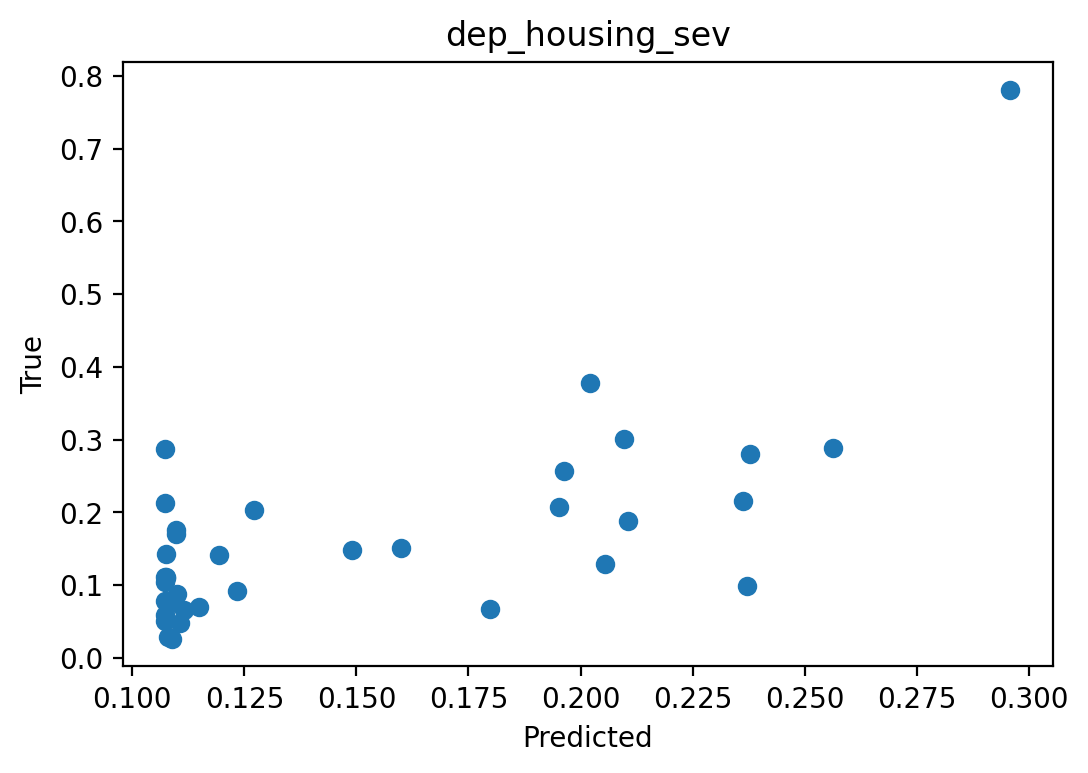

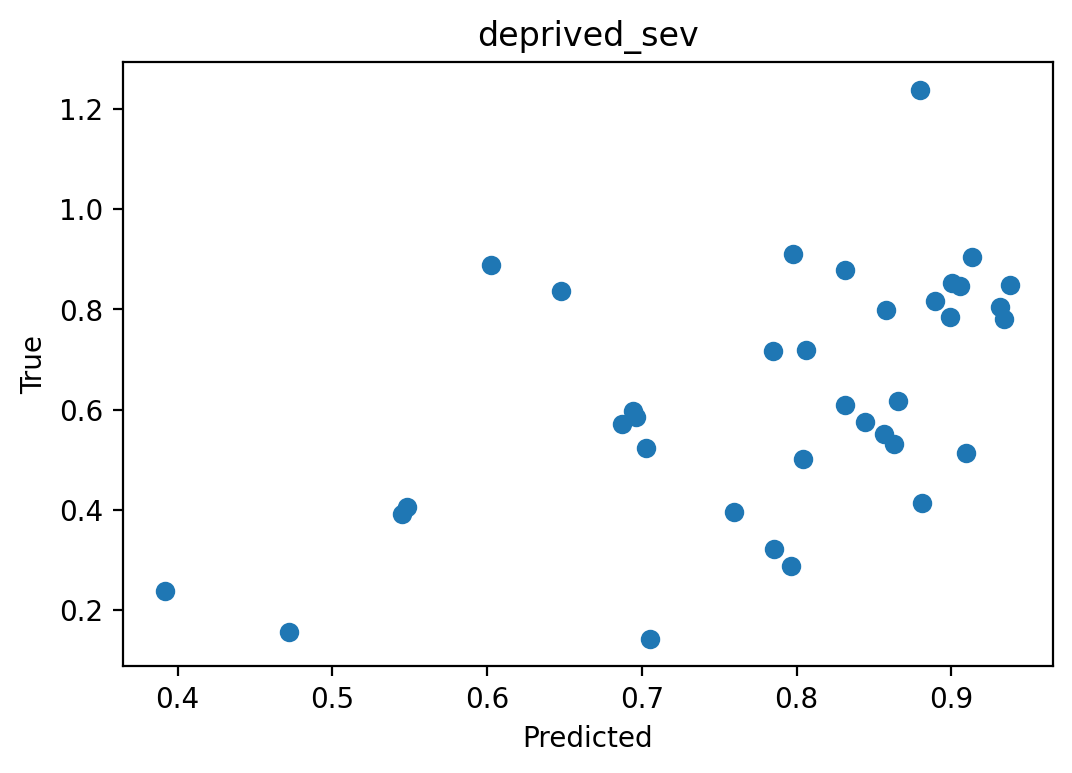

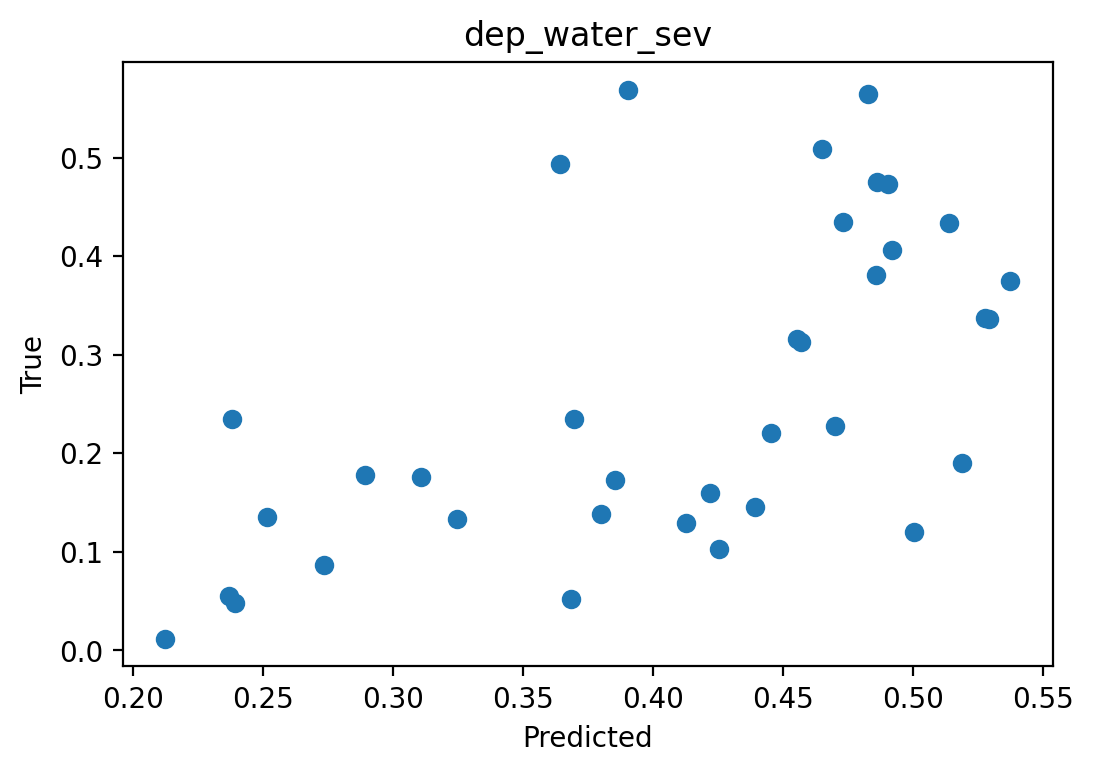

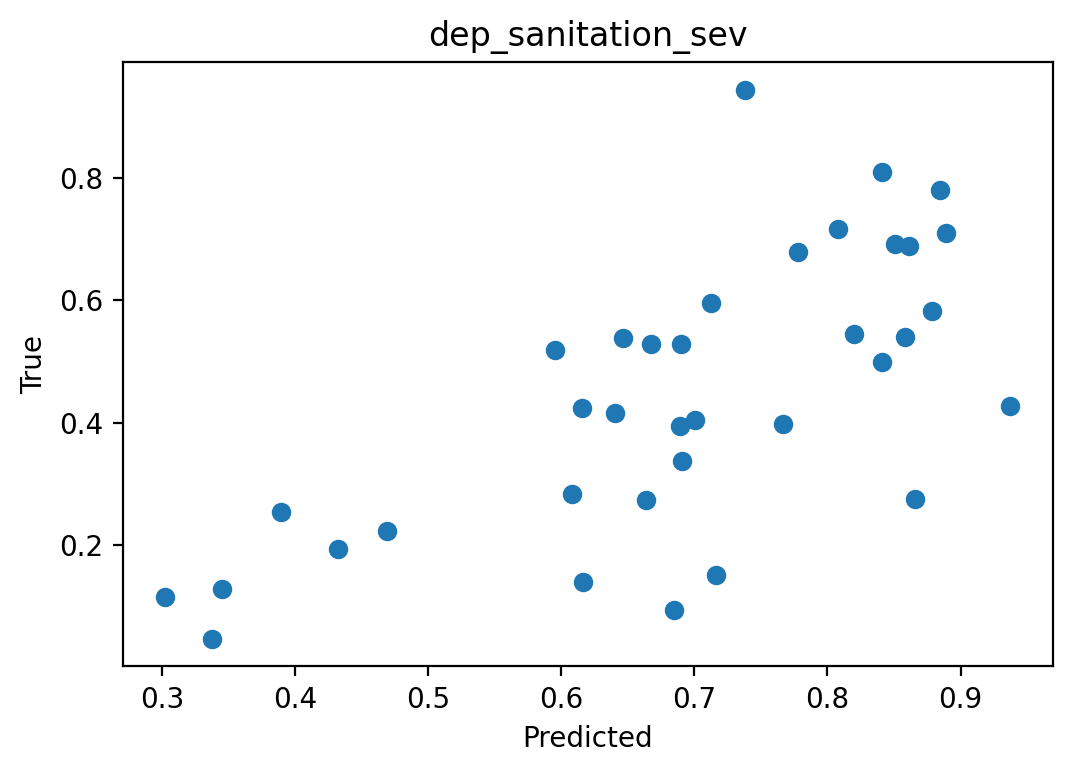

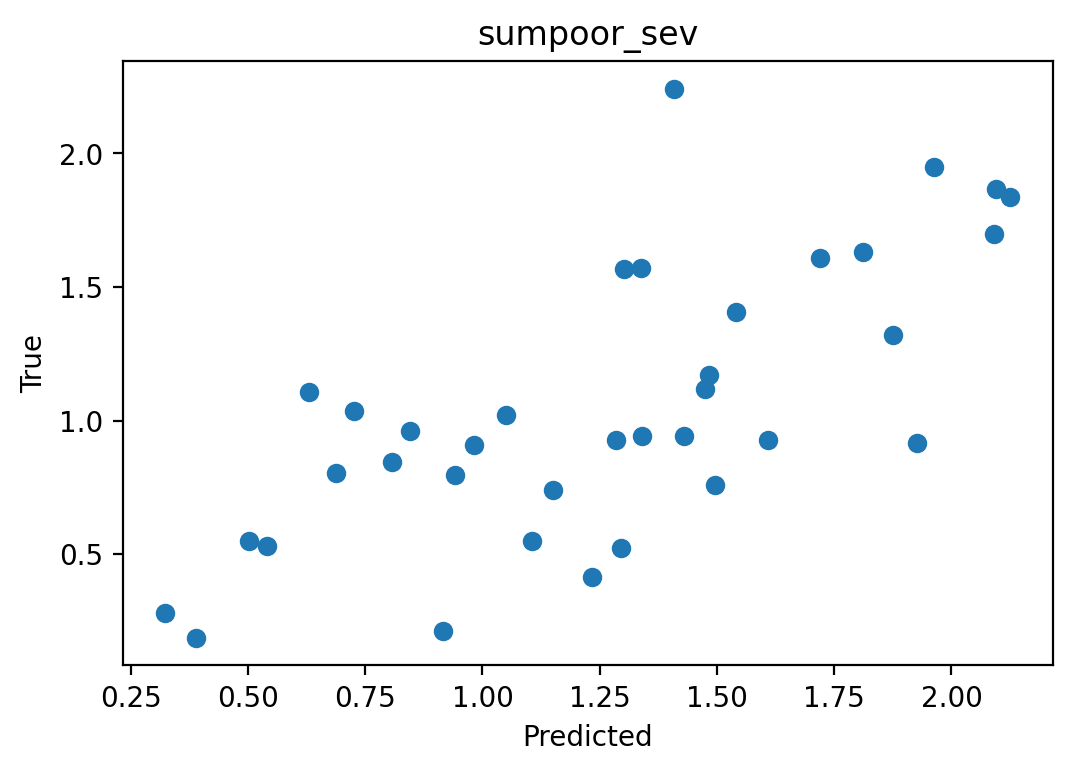

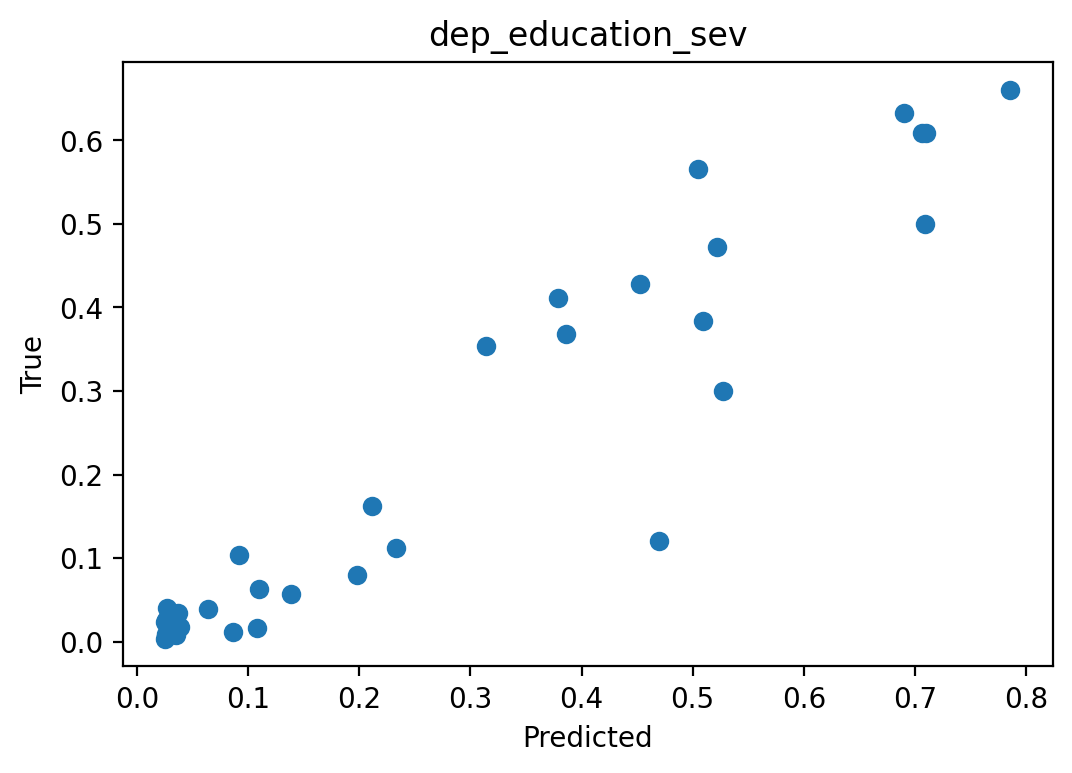

In [300]:
true_cols = [col for col in state_eval.columns if '_weighted' in col]

for true_col in true_cols: 
    col = true_col.replace('_weighted','')
    if col in state_eval.columns:
        fig,ax=plt.subplots(dpi=200)
        plt.scatter(state_eval[col],state_eval[true_col])
        ax.set_xlabel('Predicted') 
        ax.set_ylabel('True') 
        ax.set_title(col)
        plt.show() 

In [301]:
state_eval_weighted = adm1_weighted.sjoin(preds).groupby('admin1').agg(agg_dict)
true_cols = [col for col in state_eval_weighted.columns if '_weighted' in col]

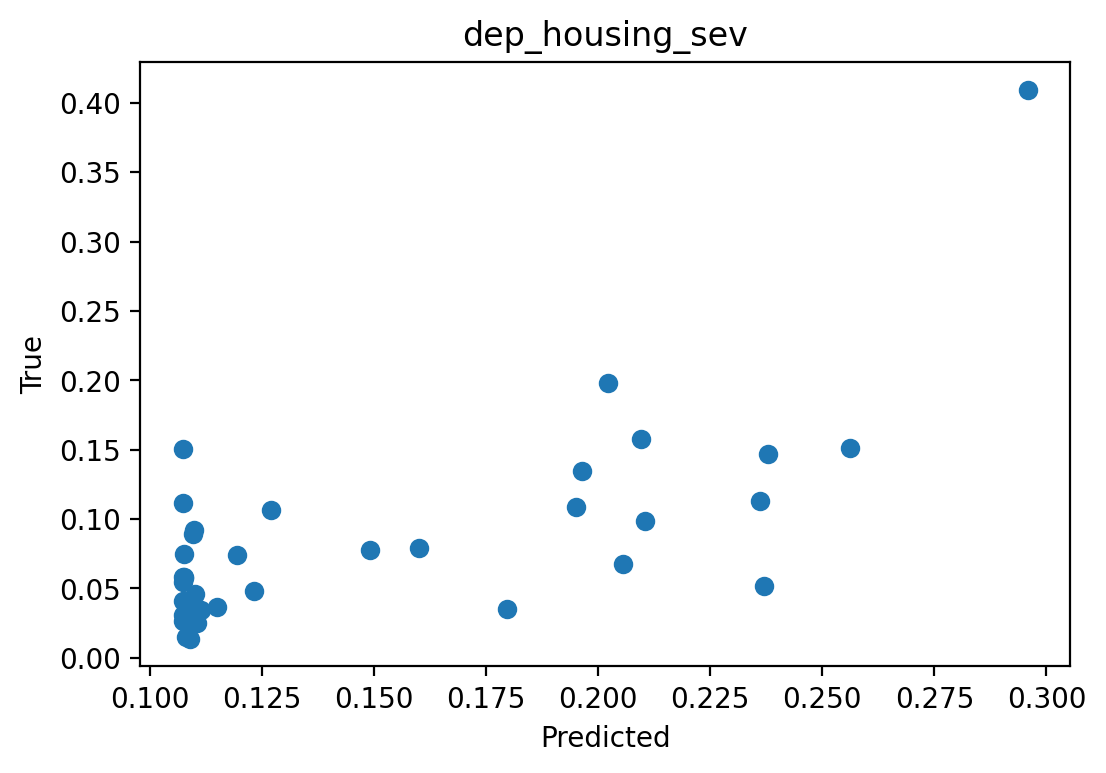

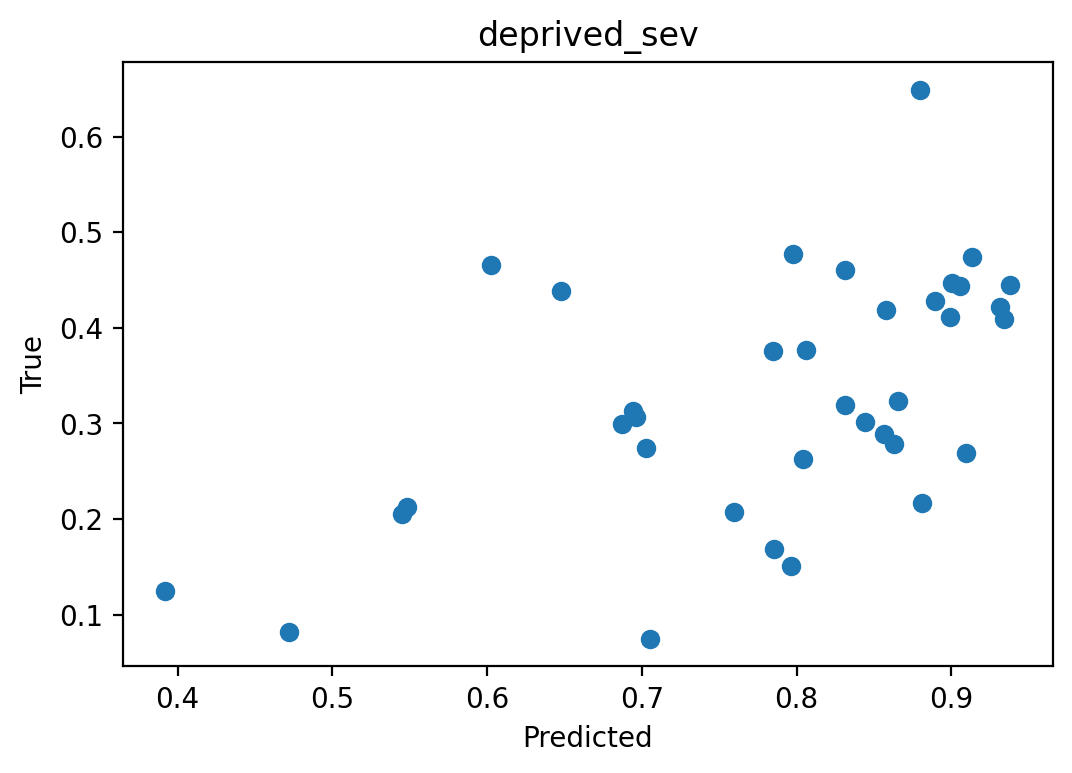

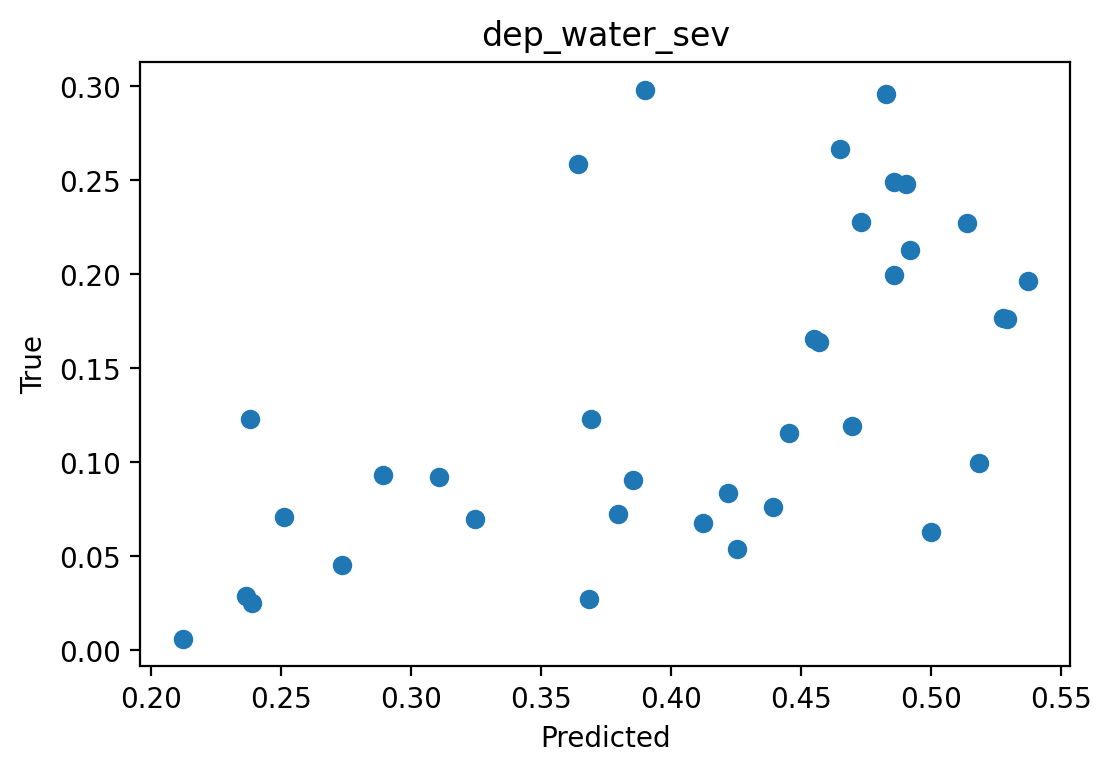

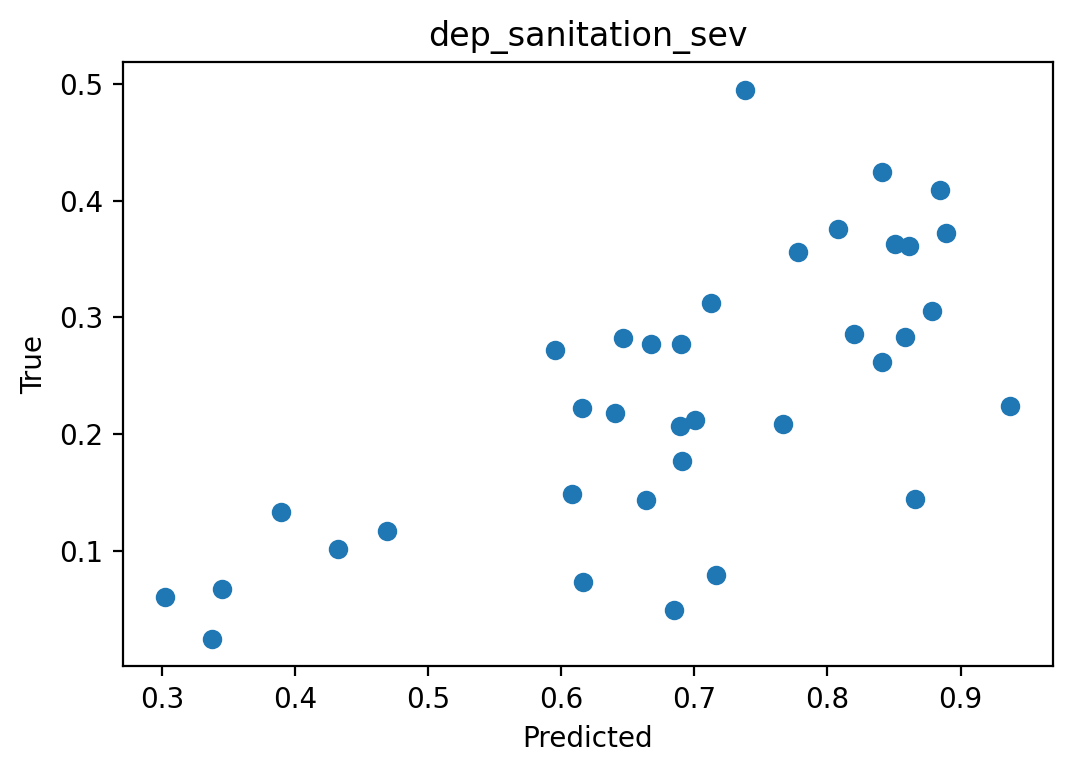

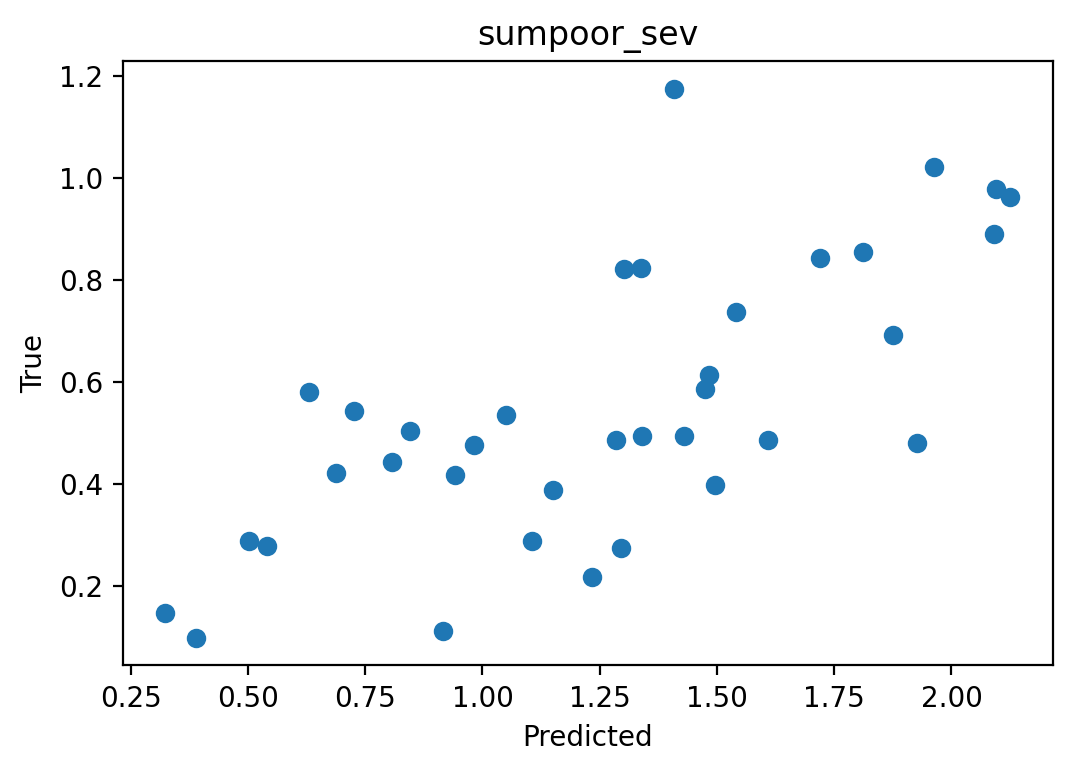

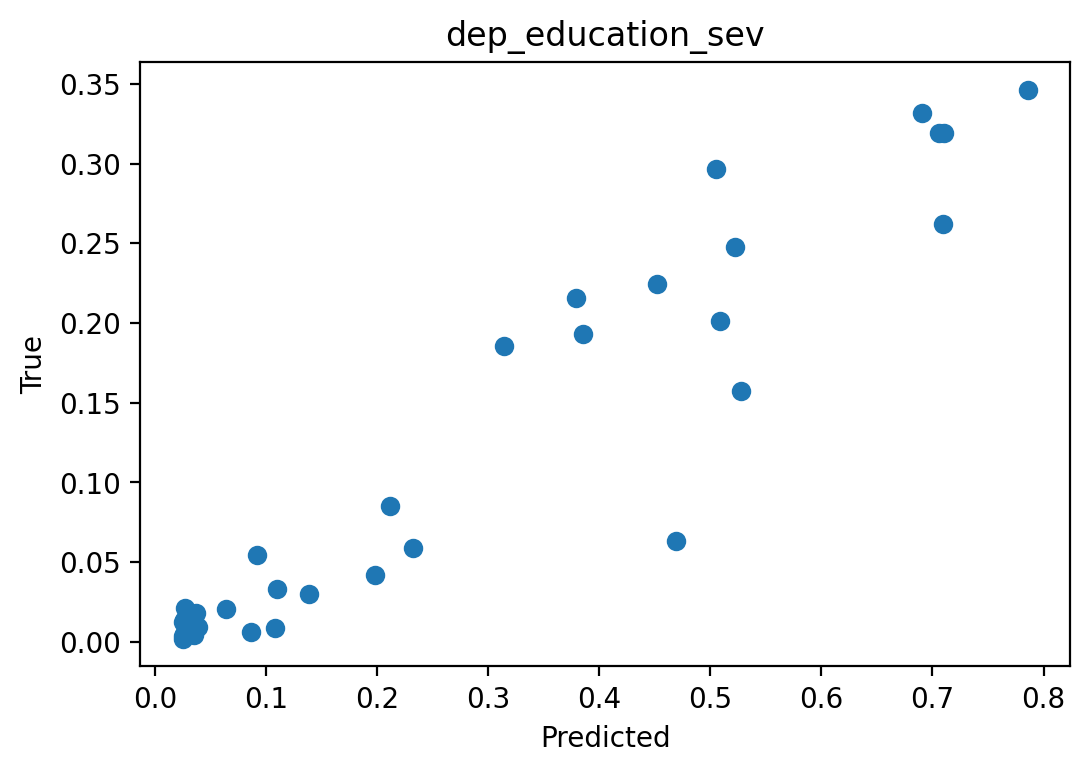

In [302]:
for true_col in true_cols: 
    col = true_col.replace('_weighted','')
    if col in state_eval_weighted.columns:
        fig,ax=plt.subplots(dpi=200)
        plt.scatter(state_eval_weighted[col],state_eval_weighted[true_col])
        ax.set_xlabel('Predicted') 
        ax.set_ylabel('True') 
        ax.set_title(col)
        plt.show() 

In [303]:
# true_col = 'deprived_sev_weighted'
# col = true_col.replace('_weighted','_pop_adj')
# eval_df = state_eval_weighted.dropna().copy()
# print(eval_df[eval_df[col].between(0.2,0.25)&eval_df[true_col].between(0.4,0.5)].index)
# eval_df[eval_df[col].between(0.2,0.25)&eval_df[true_col].between(0.4,0.5)] = np.nan 
# eval_df = eval_df.dropna() 
# true_vals = eval_df[true_col]
# pred_vals = eval_df[col] 
# pop_vals = eval_df['population']*25*20.6
# r2 = r2_score(true_vals,pred_vals) 
# rmse = np.sqrt(mse(true_vals,pred_vals)) 
# mae_est = mae(true_vals,pred_vals)
# r2_pw = r2_score(true_vals,pred_vals,sample_weight=pop_vals) 

In [304]:
r2_score(*state_eval_weighted[['dep_education_sev_weighted','dep_education_sev_pop_adj']].dropna().values.T)

0.12441014922227378

                          dep_housing_sev_weighted  dep_housing_sev_pop_adj
dep_housing_sev_weighted                  1.000000                 0.725973
dep_housing_sev_pop_adj                   0.725973                 1.000000
0.2432616703086552
0.17997461643214893
-0.351644332579343
spearmans: SpearmanrResult(correlation=0.5212690660128019, pvalue=0.0011143240983182896)


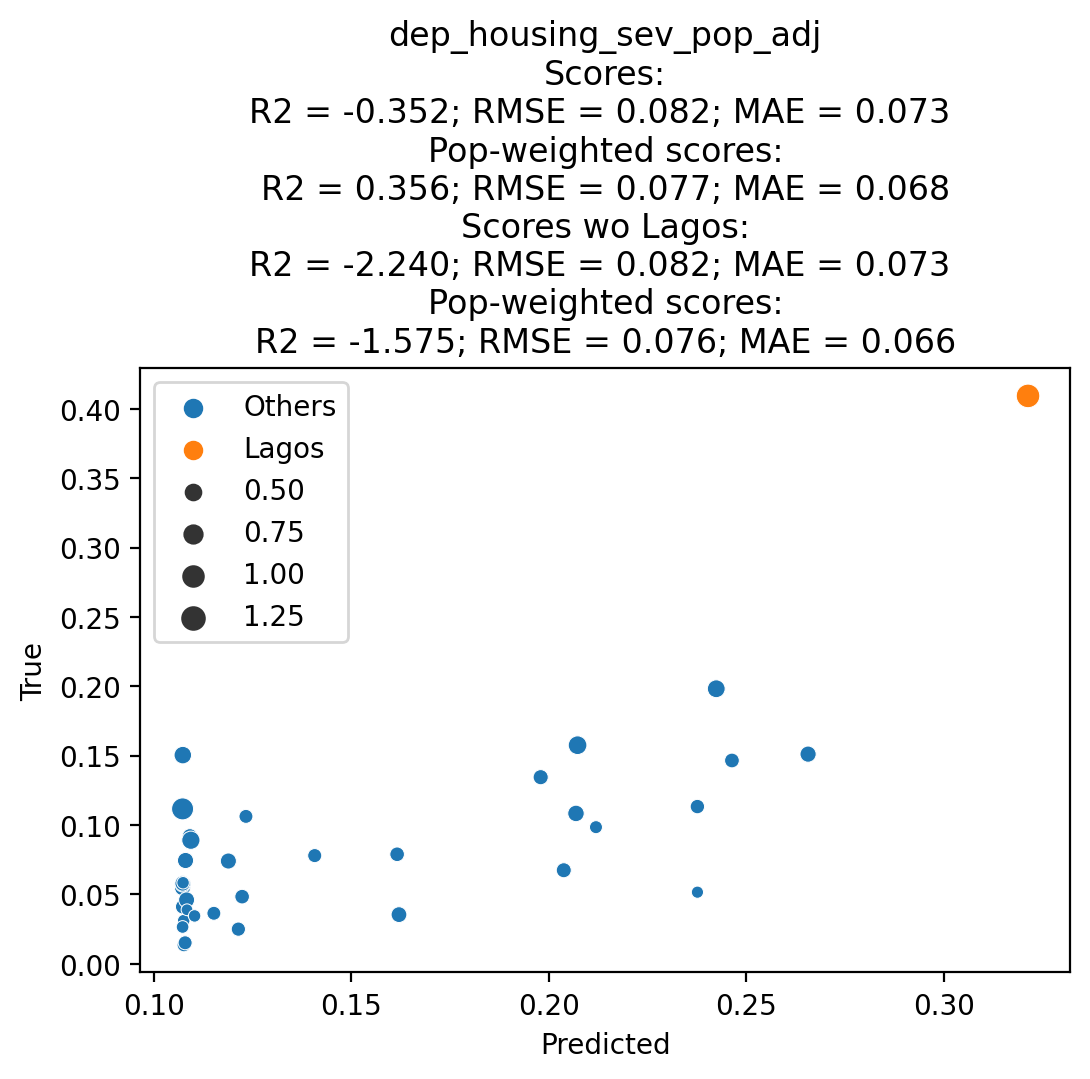

                       deprived_sev_weighted  deprived_sev_pop_adj
deprived_sev_weighted                1.00000               0.53102
deprived_sev_pop_adj                 0.53102               1.00000
4.469699914993303
0.5768969145964387
-6.747831201558823
spearmans: SpearmanrResult(correlation=0.5037323037323037, pvalue=0.001735885527128463)


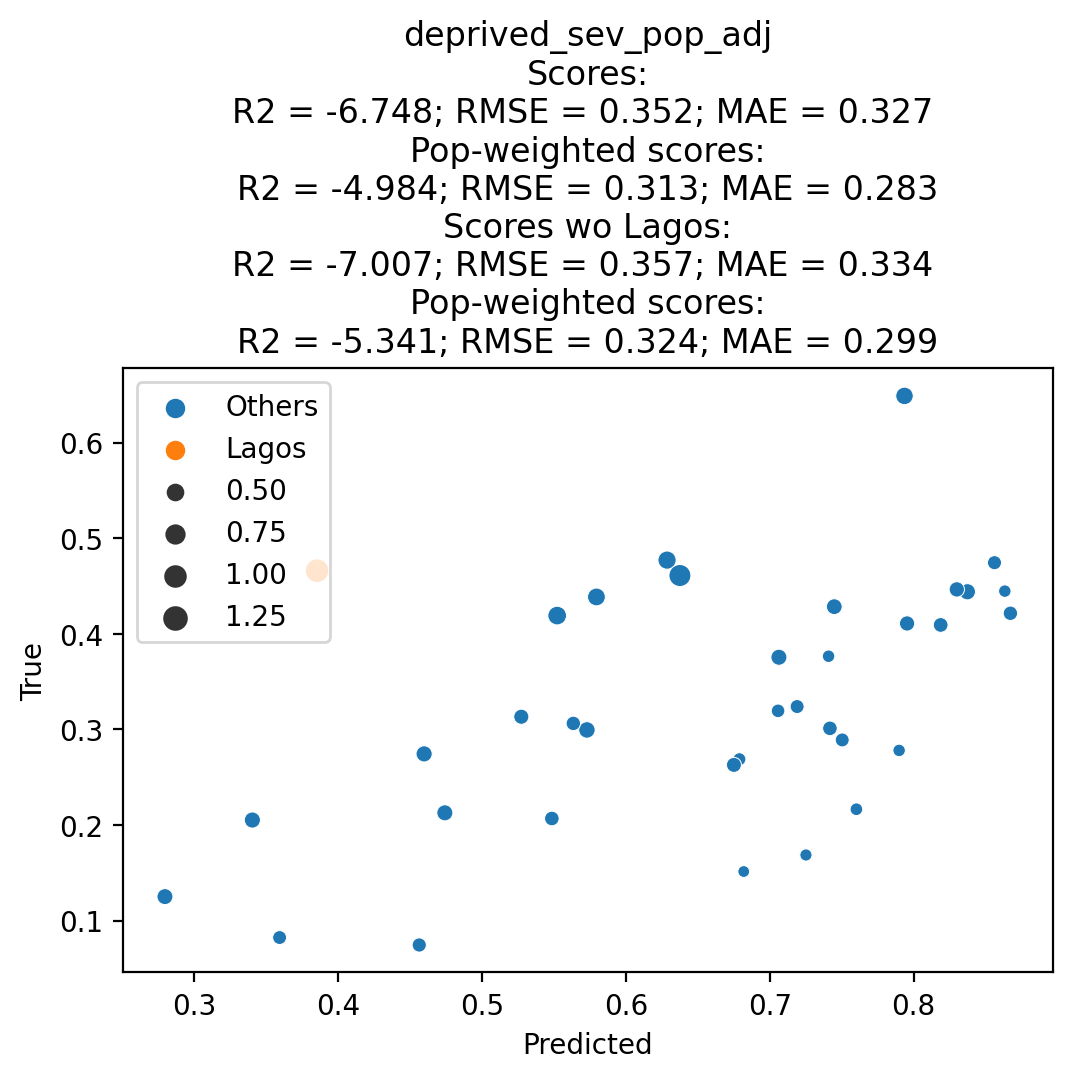

                        dep_water_sev_weighted  dep_water_sev_pop_adj
dep_water_sev_weighted                1.000000               0.646342
dep_water_sev_pop_adj                 0.646342               1.000000
0.9507263418055985
0.24914387489965673
-2.815973168870821
spearmans: SpearmanrResult(correlation=0.6308880308880309, pvalue=3.708835128882434e-05)


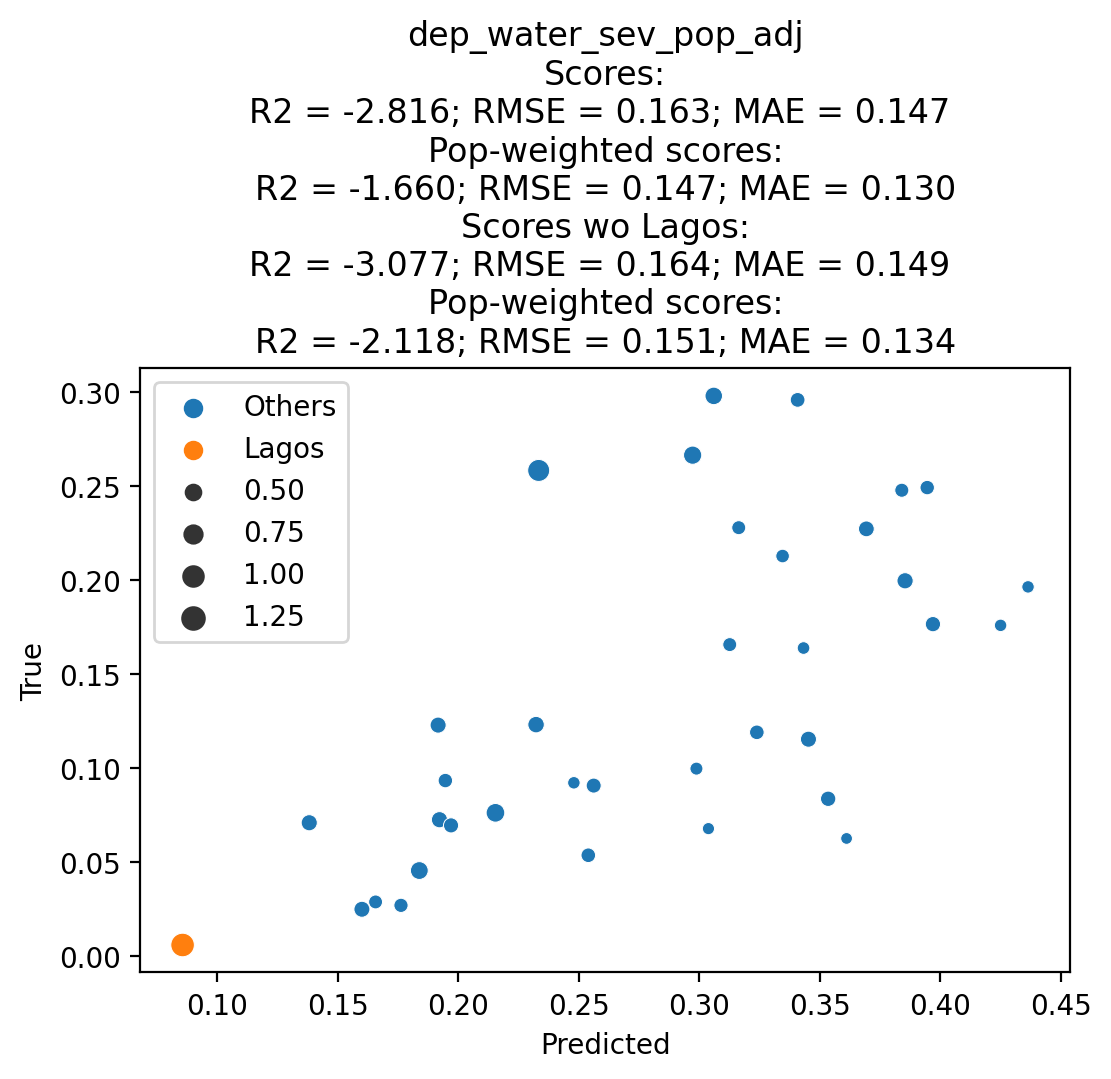

                             dep_sanitation_sev_weighted  \
dep_sanitation_sev_weighted                     1.000000   
dep_sanitation_sev_pop_adj                      0.742569   

                             dep_sanitation_sev_pop_adj  
dep_sanitation_sev_weighted                    0.742569  
dep_sanitation_sev_pop_adj                     1.000000  
3.5904223515327414
0.5027943068845203
-6.140936765533772
spearmans: SpearmanrResult(correlation=0.7598455598455599, pvalue=7.677975638617939e-08)


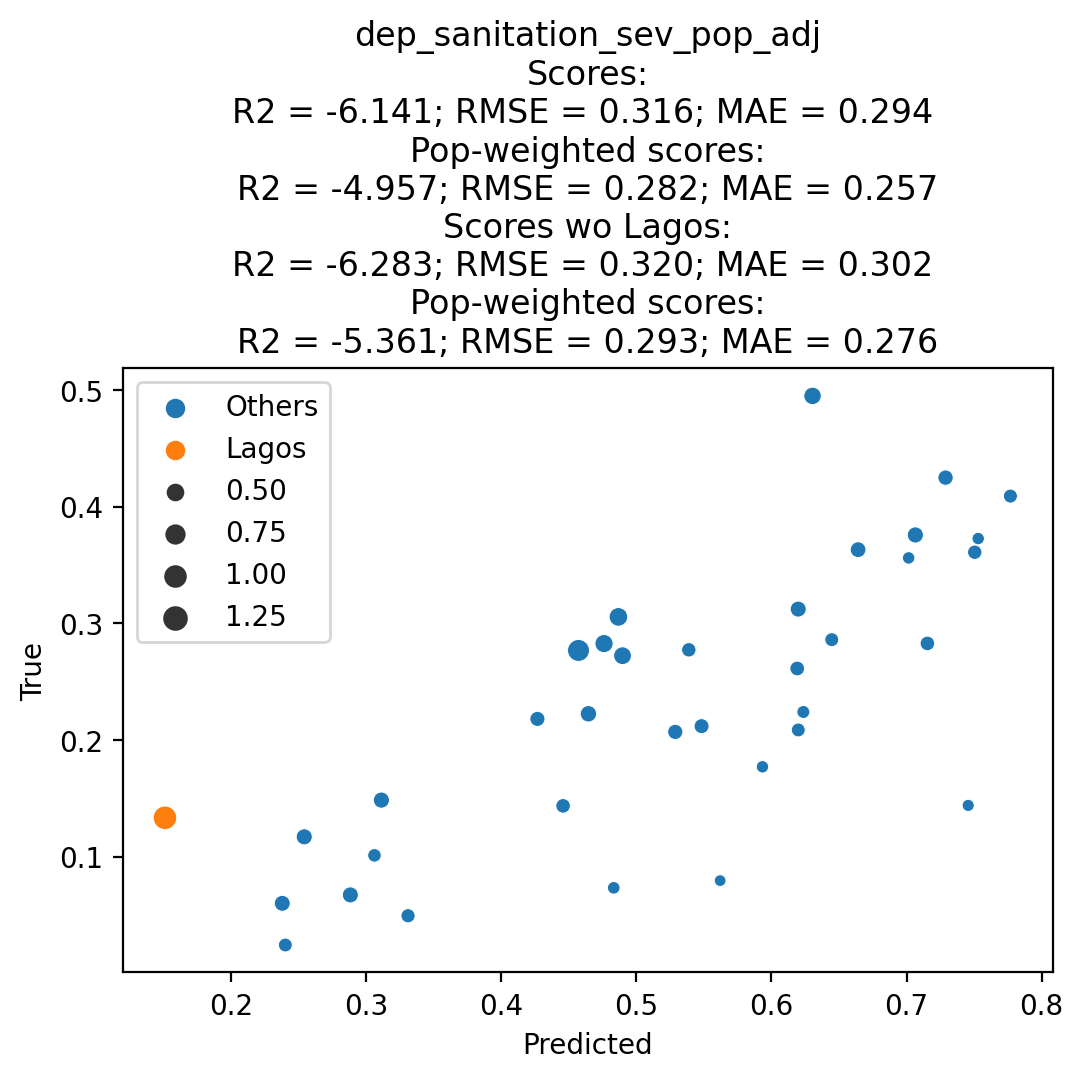

                      sumpoor_sev_weighted  sumpoor_sev_pop_adj
sumpoor_sev_weighted              1.000000             0.735844
sumpoor_sev_pop_adj               0.735844             1.000000
6.047359773800029
2.5548455228137095
-1.367015821426234
spearmans: SpearmanrResult(correlation=0.6854568854568855, pvalue=3.972481164703994e-06)


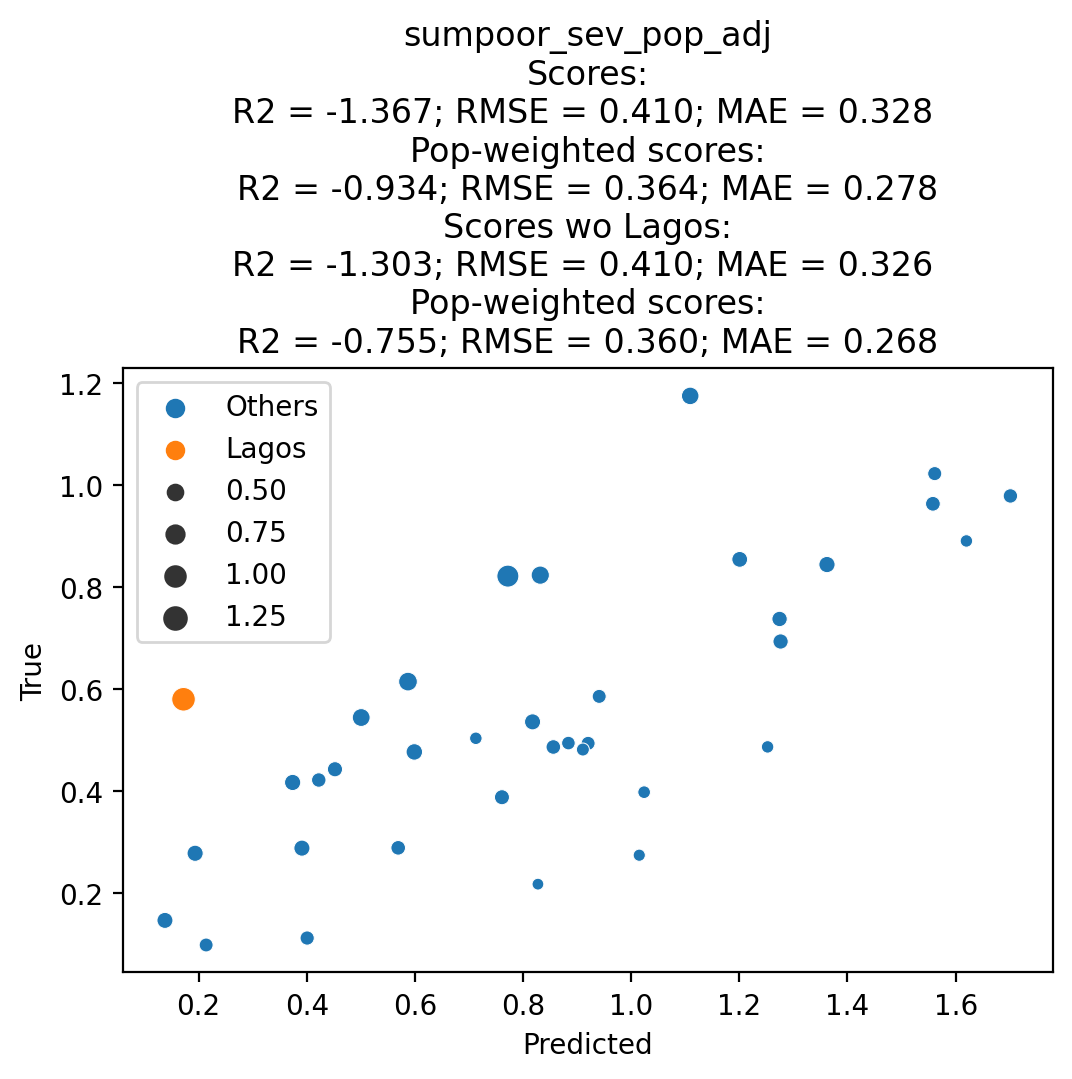

                            dep_education_sev_weighted  \
dep_education_sev_weighted                    1.000000   
dep_education_sev_pop_adj                     0.969781   

                            dep_education_sev_pop_adj  
dep_education_sev_weighted                   0.969781  
dep_education_sev_pop_adj                    1.000000  
0.4414679380782924
0.5041949009415387
0.12441014922227378
spearmans: SpearmanrResult(correlation=0.9178893178893179, pvalue=3.3172922787151577e-15)


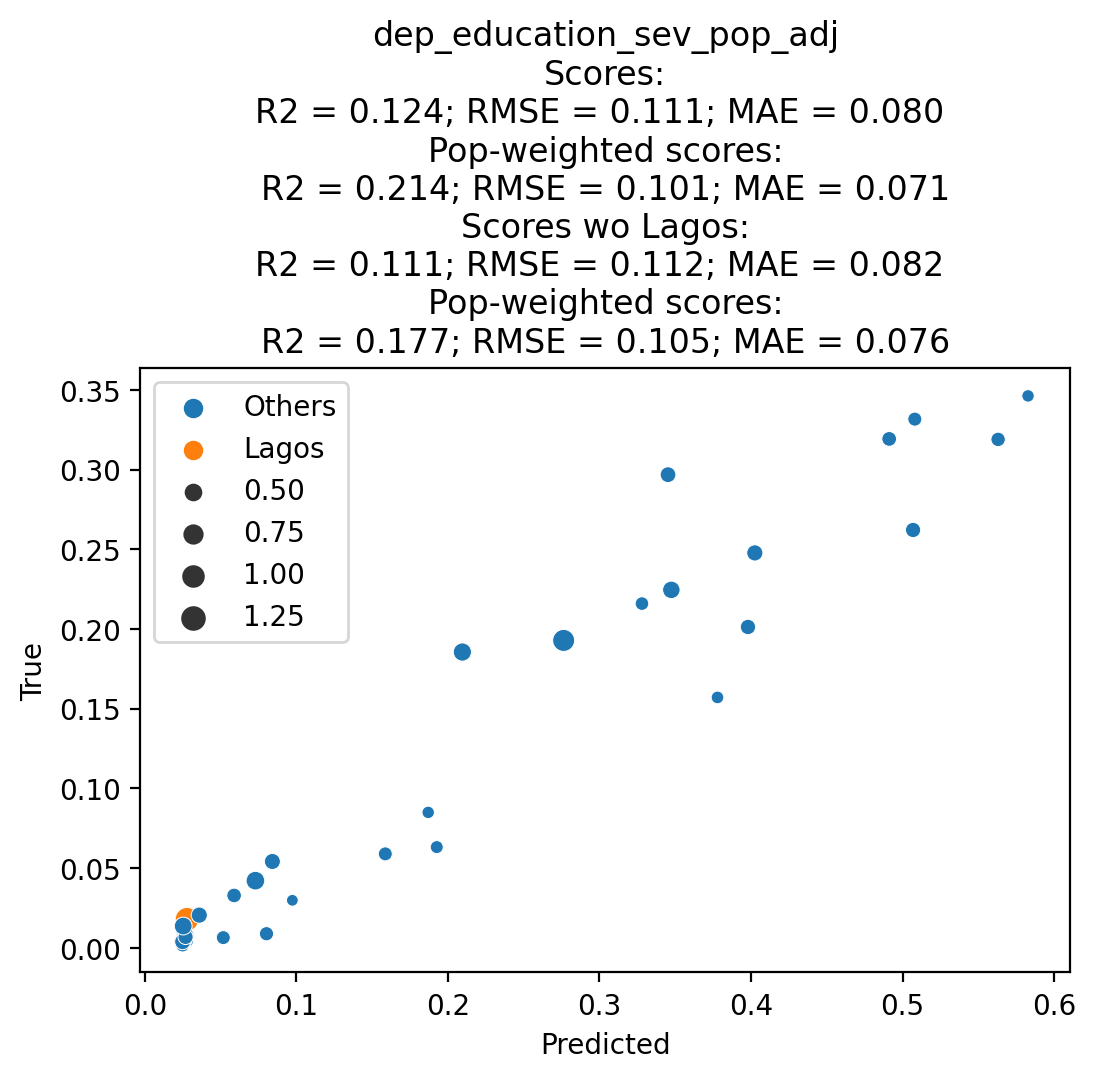

In [305]:
from scipy.stats import spearmanr

do_log = False

for true_col in true_cols:
    col = true_col.replace("_weighted", "_pop_adj")
    if col in state_eval_weighted.columns:
        fig, ax = plt.subplots(dpi=200)
        eval_df = state_eval_weighted.dropna()
        true_vals = eval_df[true_col]
        pred_vals = eval_df[col]
        pop_vals = eval_df["population"] * 25 * 20.6
        print(pd.concat([true_vals,pred_vals],axis=1).corr())
        rss = ((true_vals - pred_vals)**2).sum()
        ss = ((true_vals - true_vals.mean())**2).sum()
        print(rss) 
        print(ss)
        print(1 - rss / ss)
        print("spearmans:",spearmanr(true_vals,pred_vals))
        if do_log:
            pop_vals = np.log(pop_vals)
        sns.scatterplot(
            x=pred_vals, y=true_vals, size=pop_vals, hue=pred_vals.index == "Lagos"
        )
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        handles, labels = ax.get_legend_handles_labels()
        new_labels = ["Others", "Lagos"] + labels[2:]
        ax.legend(handles, new_labels)
        r2 = r2_score(true_vals, pred_vals)
        rmse = np.sqrt(mse(true_vals, pred_vals))
        mae_est = mae(true_vals, pred_vals)
        r2_pw = r2_score(true_vals, pred_vals, sample_weight=pop_vals)
        rmse_pw = np.sqrt(mse(true_vals, pred_vals, sample_weight=pop_vals))
        mae_est_pw = mae(true_vals, pred_vals, sample_weight=pop_vals)
        # print(f"Scores w Lagos for {col}:\nR2 = {r2:.3f}; RMSE = {rmse:.3f}; MAE = {mae_est:.3f} \nPop-weighted scores:\nR2 = {r2_pw:.3f}; RMSE = {rmse_pw:.3f}; MAE = {mae_est_pw:.3f}")
        true_vals = true_vals.loc[true_vals.index != "Lagos"]
        pred_vals = pred_vals.loc[pred_vals.index != "Lagos"]
        pop_vals = pop_vals.loc[pop_vals.index != "Lagos"]
        r2_wol = r2_score(true_vals, pred_vals)
        rmse_wol = np.sqrt(mse(true_vals, pred_vals))
        mae_est_wol = mae(true_vals, pred_vals)
        r2_pw_wol = r2_score(true_vals, pred_vals, sample_weight=pop_vals)
        rmse_pw_wol = np.sqrt(mse(true_vals, pred_vals, sample_weight=pop_vals))
        mae_est_pw_wol = mae(true_vals, pred_vals, sample_weight=pop_vals)
        # print(f"Scores wo Lagos:\nR2 = {r2:.3f}; RMSE = {rmse:.3f}; MAE = {mae_est:.3f} \nPop-weighted scores:\nR2 = {r2_pw:.3f}; RMSE = {rmse_pw:.3f}; MAE = {mae_est_pw:.3f}")
        ax.set_title(
            f"{col}\nScores:\nR2 = {r2:.3f}; RMSE = {rmse:.3f}; MAE = {mae_est:.3f} \nPop-weighted scores:\nR2 = {r2_pw:.3f}; RMSE = {rmse_pw:.3f}; MAE = {mae_est_pw:.3f}\nScores wo Lagos:\nR2 = {r2_wol:.3f}; RMSE = {rmse_wol:.3f}; MAE = {mae_est_wol:.3f} \nPop-weighted scores:\nR2 = {r2_pw_wol:.3f}; RMSE = {rmse_pw_wol:.3f}; MAE = {mae_est_pw_wol:.3f}"
        )
        plt.show()
        fig.savefig(f'../data/figures/nga_state_{col}_lagos_hl.png',bbox_inches = "tight")


In [ ]:
tmp = pd.read_csv('../data/models/cluster_runs.csv')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
tmp.head()

In [ ]:
# 7 x all, senegal, guinea, benin, sierra leone, liberia, cameroon, burkina faso, togo
tmp.dropna(subset='Name',inplace=True)
tmp['country'] = np.repeat(['all', 'senegal', 'guinea', 'benin', 'sierra leone', 'liberia', 'cameroon', 'burkina faso', 'togo'], 7)

In [ ]:
scores = tmp.groupby(by=['Name'],as_index=False)[['country','Name','mae','r2_score','rmse']].transform(lambda x: x)

In [ ]:
scores.head()

In [ ]:
# sns.scatterplot(data=scores,y='mae')
# plt.show()
countries = ['all', 'senegal', 'guinea', 'benin', 'sierra leone', 'liberia', 'cameroon', 'burkina faso', 'togo'] 
countries = [ctry.title() for ctry in countries]
targets = tmp.Name.unique().tolist() 

fig,ax = plt.subplots(dpi=150)
scores.loc[scores.r2_score<0,'r2_score'] = 0 # threshold to zero for vis
sns.barplot(data=scores,x='country',y='mae',hue='Name',ax=ax) 
fig2,ax2 = plt.subplots(dpi=150)
sns.barplot(data=scores,x='country',y='rmse',hue='Name',ax=ax2) 
fig3,ax3 = plt.subplots(dpi=150)
sns.barplot(data=scores,x='country',y='r2_score',hue='Name',ax=ax3) 
ax.set_ylabel('MAE')
ax.set_xlabel('Country')
ax.set_xticklabels(countries, rotation=40, ha='right')
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Av. dep. prev.", "Av. dep. sev.", "Av. prop. 2+ deps.", "Edu. dep.","San. dep.","Water dep.","Housing dep."]
ax.legend(handles, new_labels)
        
ax2.set_ylabel('RMSE')
ax2.set_xlabel('Country')
ax2.set_xticklabels(countries, rotation=40, ha='right')
leg = ax2.get_legend() 
leg.remove()
# handles, labels = ax2.get_legend_handles_labels()
# new_labels = ["Av. dep. prev.", "Av. dep. sev.", "Av. prop. 2+ deps.", "Edu. dep.","San. dep.","Water dep.","Housing dep."]
# ax2.legend(handles, new_labels)

ax3.set_ylabel('R2 score')
ax3.set_xlabel('Country')
ax3.set_xticklabels(countries, rotation=40, ha='right')
leg = ax3.get_legend() 
leg.remove()
# handles, labels = ax3.get_legend_handles_labels()
# new_labels = ["Av. dep. prev.", "Av. dep. sev.", "Av. prop. 2+ deps.", "Edu. dep.","San. dep.","Water dep.","Housing dep."]


plt.show() 

In [ ]:
print(*countries,sep=', ')

In [ ]:
DATA_DIRECTORY = Path('../data/processed')
clean_name = 'hexes_nigeria_res7_thres30.csv'
XY = pd.read_csv(DATA_DIRECTORY / clean_name)
expanded_gt = pd.read_csv(
    DATA_DIRECTORY
    / f"expanded_nigeria_res7_thres30.csv"
)
# arbitrarily remove duplicate hexes
expanded_gt.drop_duplicates(subset=["hex_code"], inplace=True)

# contains both count and mean value for targets
# so currently as not using count beyond
# thresholding just clean and drop
expanded_gt.drop(
    columns=[col for col in expanded_gt.columns if "_count" in col],
    inplace=True,
)
expanded_gt.rename(
    columns={col: col.replace("_mean", "") for col in expanded_gt.columns},inplace=True
)
expanded_gt.set_index("hex_code", inplace=True)
cols = expanded_gt.columns.tolist() 
cols = [col.replace('_prev','_sev') for col in cols]
cols = ['dep_'+col if '_sev' in col and 'sumpoor' not in col and 'deprived' not in col else col for col in cols]
expanded_gt.columns = cols
expanded_gt.drop(columns=[col for col in expanded_gt.columns if '_sev' not in col],inplace=True)
# replace original gt with expanded gt
col_order = XY.columns.tolist()
XY[expanded_gt.columns.tolist()] = np.nan
XY = XY.set_index("hex_code").combine_first(expanded_gt).reset_index()
XY = XY[col_order] # ensure in correct original order